In [1]:
#############################################   importing packages     #############################################
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import os 
from matplotlib_venn import venn3
import pyper as pr
import statistics
from lifelines import CoxPHFitter
import plotly
from plotly.offline import plot
import plotly.graph_objs as go
from decimal import Decimal

In [2]:
##########################################   defining functions      ##############################################

# Mostly used function
def Drop(space):
    space['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
    space.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
    return(space)

def Fetch_first(df):
    df['PRIMARY_DIAGNOSIS']=df['PRIMARY_DIAGNOSIS'].astype(str)
    df['site_ICD10']=df['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
    return df

def grouping(df,column):
    
    grouped_df = df.groupby(column)['PSEUDO_PATIENTID'].nunique()
    
    return grouped_df

# not usually used, since G1 G4 GX were also allowed to exist
def replace(a):
    if a['GRADE'] == 'GX':
        return ('G3')
    elif a['GRADE'] == 'G4':
        return ('G3')
    elif a['GRADE'] == 'G3':
        return ('G3')
    elif a['GRADE'] == 'G2':
        return ('G2')
    elif a['GRADE'] == 'G1':
        return ('G2')
    else:
        return('G3')
    
# do not add return NA
def conditions(s):
    if s['VITALSTATUS'] == 'D':
        return(1)
    elif s['VITALSTATUS'] == 'A':
        return(0)

def SurvivalDrug(df, group):
    g=df.loc[(df['seq'] == group) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_NEW'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_NEW'], label = group)
    kmf.plot(ci_show=False)
    plt.xlabel('days')
    plt.ylabel('Survival Probability')
    
def SurvivalGrade(df, grade):
    g = df.loc[(df['GRADE'] == grade) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = grade)
    kmf.plot(title='Survival curve by Grade')
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))
    
# concrete detail about survival time and censored number
def SurvivalAGE(df, AG):
    g = df.loc[(df['Agroup'] == AG) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = AG)
    # kmf.plot_survival_function(at_risk_counts=True)
    kmf.plot(title='Survival curve by age')
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))
   
# JUST curious
def SurvivalSEX(df, SEX):
    g = df.loc[(df['Sgroup'] == SEX) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = SEX)
  
    kmf.plot(title='Survival curve by sex', ci_show=False)
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print('Median survival', SEX, ': ', kmf.median_survival_time_)
    
# JUST curious
def SurvivalINCOME(df, INCOME):
    g = df.loc[(df['Igroup'] == INCOME) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = INCOME)
    kmf.plot(title='Survival curve by income', ci_show=False)
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
       
# JUST curious
def SurvivalSITE(df, SITE):
    g = df.loc[(df['OPERTN_'] == SITE) & (df['INTERVAL_DIAG_TO_VS'] != '')]
    g['VITALSTATUS_new'] = g.apply(conditions, axis=1)
    kmf = KaplanMeierFitter()
    kmf.fit(durations = g['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = g['VITALSTATUS_new'], label = SITE)
    # kmf.plot_survival_function(at_risk_counts=True)
    kmf.plot(title='Survival curve by Top 5 Surgeries in oligo', ci_show=False)
    plt.ylim(0,1)
    plt.xlabel('days')
    plt.ylabel("Survival probability")
    print('Median survival', SITE, ': ', kmf.median_survival_time_)

        

In [3]:
############################ Change the working directory to connect to the database ###############################
print(os.getcwd())
os.chdir('/data/master/DS175/share/0_Database')
print(os.getcwd())

# Connect to the database
conn = sqlite3.connect('Gliocova.db')
cur = conn.cursor()

tum_pat = pd.read_sql('SELECT * FROM TUM_PAT;', conn)

/data/master/DS175/share/19_Rare tumours
/data/master/DS175/share/0_Database


# Age describe for all patients

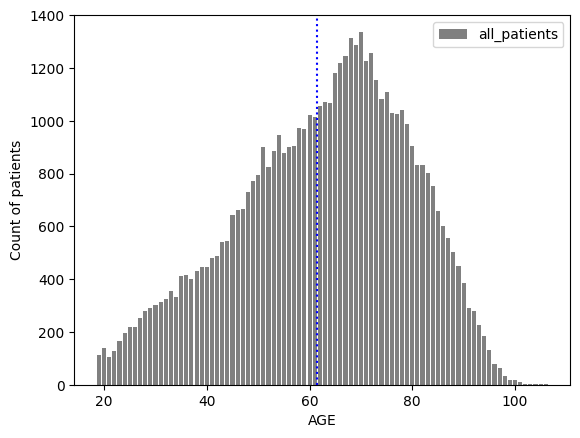

In [4]:
##################################### bar chart of all patients #####################################################
# Y=tum_pat.groupby('AGE')['PSEUDO_PATIENTID'].nunique()
# 19 = 18(min age) + 1(python start index from 0)
plt.bar(19+np.arange(0, 88), tum_pat.groupby('AGE')['PSEUDO_PATIENTID'].count(), color='grey', label = 'all_patients')
plt.ylim(0, 1400)
plt.xlabel('AGE')
plt.ylabel('Count of patients')
plt.axvline(np.mean(tum_pat['AGE']), color='b', linestyle = 'dotted')
plt.legend()



In [5]:
tum_pat['AGE'].describe()

count    52106.000000
mean        61.504184
std         16.932872
min         18.000000
25%         50.000000
50%         64.000000
75%         74.000000
max        107.000000
Name: AGE, dtype: float64

In [6]:
statistics.median(tum_pat['AGE'])

64.0

## Number of oligo paitents in different tables (abandoned)

In [7]:
# df_C = pd.read_sql("SELECT * FROM TUM_PAT WHERE (SITE_ICD10_O2 LIKE 'C70%' OR SITE_ICD10_O2 lIKE'C71%' OR SITE_ICD10_O2 LIKE 'C72%') AND (MORPH_ICD10_O2 IN (9450, 9451, 9460));",conn)
# df_C.drop_duplicates(subset='PSEUDO_PATIENTID',inplace=True)
# df_C['PSEUDO_PATIENTID'].nunique()
### Only Query Histology Code 9450,9451 and SITE ICD Code C70,C71,C72 and starting claening here.
### There is 1 patient in 9460, but this should not happened since update in Morphology Code O3 firstly used 9460 as Anaplastic Oligo
### Here the dataset is based on Morphology O2, the extra 9460 patient could be error
### All in all, only 1 patient had no statistical meaning, so deleted

In [8]:
# df_C.groupby('SITE_ICD10_O2')['PSEUDO_PATIENTID'].nunique()

## Seems like there is really no Code starting with D

In [9]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 0 patients is not in Diagnosis year 2013,2014,2015,2016,2017,2018

1364

In [10]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_')  AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 9 patients had no records of Ethnicity

1364

In [11]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 5 patients had no records of VITALSTATUS

1355

In [12]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 15 patients had no records of INTERVAL_DIAG_TO_VS

1350

In [13]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df['PSEUDO_PATIENTID'].nunique()
### 3 patients' SITE ICD were from D32 

1335

In [14]:
df = pd.read_sql("SELECT * FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2','G3','GX','')) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_') AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (SITE_ICD10_O2 LIKE 'C70_' OR SITE_ICD10_O2 lIKE'C71_' OR SITE_ICD10_O2 LIKE 'C72_');",conn)
df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
df['PSEUDO_PATIENTID'].nunique()
### 48 patients were not in (G2,G3,GX,NA)

1287

In [15]:
# G1/4 should be directly deleted, since all papers do so. But GX and NA should be considered
# one evidence for remaining these groups is according to WHO 2016 classification of CNS tumours' Morphology codes and WHO grades table,
# 9450/3, label Oligodendroglioma, NOS could be any grades
# 9451/3, label Anaplastic oligodendroglioma, NOS could be any grades (remains * in the WHO grade column, means all)

## check patients with mutiple morphology codes

In [16]:
tum_pat = pd.read_sql('SELECT * FROM TUM_PAT;', conn)
multi_oligo=tum_pat[tum_pat['PSEUDO_PATIENTID'].isin(df['PSEUDO_PATIENTID'])]
multi_oligo.groupby('MORPH_ICD10_O2')['PSEUDO_PATIENTID'].nunique()

MORPH_ICD10_O2
9380      1
9382      1
9401      3
9420      1
9440      5
9450    773
9451    522
9530      2
9537      1
Name: PSEUDO_PATIENTID, dtype: int64

In [17]:
EX=('9380', '9382', '9401', '9420', '9440', '9530', '9537')

oligo_withOther=multi_oligo.query('MORPH_ICD10_O2 in @EX') 
print('patient number with mixed tumour', oligo_withOther['PSEUDO_PATIENTID'].nunique())

patient number with mixed tumour 14


In [18]:
df=multi_oligo[~multi_oligo['PSEUDO_PATIENTID'].isin(oligo_withOther['PSEUDO_PATIENTID'])]
df.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# drop NA of INTERVAL
df['INTERVAL_DIAG_TO_VS'].replace('', np.nan,inplace=True)
df.dropna(subset='INTERVAL_DIAG_TO_VS', inplace=True)
df['VITALSTATUS'].replace('', np.nan,inplace=True)
df.dropna(subset='VITALSTATUS', inplace=True)
df['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_641545/4103953176.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/4103953176.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/4103953176.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/4103953176.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

1271

In [19]:
df.groupby('MORPH_ICD10_O2')['PSEUDO_PATIENTID'].nunique()

MORPH_ICD10_O2
9450    759
9451    512
Name: PSEUDO_PATIENTID, dtype: int64

## Look into details of Site codes

In [20]:
################################ Index from TUM_PAT to get the ICD10_O2 diagnosis code ##############################

df['S'] = df['SITE_ICD10_O2'].astype(str).str[:3]

C = ('C70', 'C71', 'C72')
df_SiteC = df[df['S'].isin(C)]
df_SiteC.groupby(['SEX', 'SITE_ICD10_O2'])['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_641545/3326364496.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



SEX  SITE_ICD10_O2
1    C710              22
     C711             363
     C712             104
     C713              79
     C714              15
     C718              16
     C719              65
2    C710              24
     C711             368
     C712              80
     C713              60
     C714               7
     C716               1
     C718              13
     C719              53
     C725               1
Name: PSEUDO_PATIENTID, dtype: int64

In [21]:
df_SiteC['PSEUDO_PATIENTID'].nunique()

1271

In [23]:
D = ('D32', 'D33', 'D35')
df_SiteD = df[df.S.isin(D)]
df_SiteD.groupby(['SEX', 'S'])['PSEUDO_PATIENTID'].nunique()

## There should not be any benign tumour for oligo

Series([], Name: PSEUDO_PATIENTID, dtype: int64)

## Reassign df_SiteC to df again, remember to run the cells in order

In [24]:
df=df_SiteC
df['PSEUDO_PATIENTID'].nunique()

1271

In [25]:
df.groupby('BASISOFDIAGNOSIS')['PSEUDO_PATIENTID'].nunique()

BASISOFDIAGNOSIS
1       4
2      52
7    1215
Name: PSEUDO_PATIENTID, dtype: int64

In [26]:
52/1271

0.040912667191188044

In [27]:
df.groupby('SITE_ICD10_O2')['PSEUDO_PATIENTID'].nunique()

SITE_ICD10_O2
C710     46
C711    731
C712    184
C713    139
C714     22
C716      1
C718     29
C719    118
C725      1
Name: PSEUDO_PATIENTID, dtype: int64

In [28]:
df['AGE'].describe()

count    1271.000000
mean       46.996066
std        14.351739
min        18.000000
25%        36.000000
50%        46.000000
75%        57.000000
max        99.000000
Name: AGE, dtype: float64

In [29]:
df.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    664
2    607
Name: PSEUDO_PATIENTID, dtype: int64

In [30]:
df.groupby('ETHNICITYNAME')['PSEUDO_PATIENTID'].nunique()

ETHNICITYNAME
ANY OTHER ASIAN BACKGROUND           27
ANY OTHER BLACK BACKGROUND            1
ANY OTHER ETHNIC GROUP               31
ANY OTHER MIXED BACKGROUND            2
ANY OTHER WHITE BACKGROUND           89
ASIAN INDIAN                         30
ASIAN PAKISTANI                      21
BLACK AFRICAN                         5
BLACK CARIBBEAN                       8
CHINESE                               5
MIXED WHITE AND ASIAN                 3
MIXED WHITE AND BLACK CARIBBEAN       3
NOT KNOWN                             7
NOT STATED                           19
WHITE BRITISH                      1012
WHITE IRISH                           8
Name: PSEUDO_PATIENTID, dtype: int64

In [31]:
df.groupby('INCOME_QUINTILE_2015')['PSEUDO_PATIENTID'].nunique()

INCOME_QUINTILE_2015
1 - Least deprived    268
2                     270
3                     264
4                     222
5 - Most deprived     247
Name: PSEUDO_PATIENTID, dtype: int64

In [32]:
(247)/1271

0.1943351691581432

In [33]:
df.groupby(['SEX', 'DIAGNOSISYEAR'])['PSEUDO_PATIENTID'].nunique()

SEX  DIAGNOSISYEAR
1    2013              82
     2014              98
     2015             120
     2016             134
     2017             121
     2018             109
2    2013              92
     2014             101
     2015              94
     2016             106
     2017              99
     2018             115
Name: PSEUDO_PATIENTID, dtype: int64

/tmp/ipykernel_641545/221912568.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/221912568.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot: xlabel='timeline'>

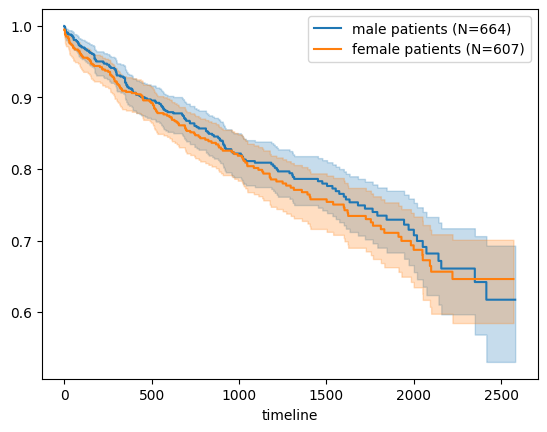

In [34]:
df_male=df[df.SEX == 1]
df_female=df[df.SEX == 2]
kmf=KaplanMeierFitter()

df_male['VITALSTATUS_NEW'] = df_male.apply(conditions, axis = 1)
male=kmf.fit(durations = df_male['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_male['VITALSTATUS_NEW'], label = 'male patients (N=664)')
kmf.plot()

df_female['VITALSTATUS_NEW'] = df_female.apply(conditions, axis = 1)
female=kmf.fit(durations = df_female['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_female['VITALSTATUS_NEW'], label = 'female patients (N=607)')
kmf.plot()


In [35]:
S_results = logrank_test(df_male['INTERVAL_DIAG_TO_VS'], df_female['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = df_male.apply(conditions,axis=1).astype(int),
                       event_observed_B = df_female.apply(conditions,axis=1).astype(int))
S_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.25 0.62      0.70

## 10 years AGE grouping, bar charts

In [36]:
######################################### 10 year gap, oligo patients' ages ############################################

df_male = df[df['SEX']==1]
df_male = df_male.drop_duplicates(subset=['PSEUDO_PATIENTID'])

df_female = df[df['SEX']==2]
df_female = df_female.drop_duplicates(subset=['PSEUDO_PATIENTID'])

df_male['AGE'].astype(int)
df_female['AGE'].astype(int)

df_male.loc[(17 < df_male.AGE) & (df_male.AGE < 21), 'group'] = '18_20'
df_male.loc[(20 < df_male.AGE) & (df_male.AGE < 31), 'group'] = '21_30'
df_male.loc[(30 < df_male.AGE) & (df_male.AGE < 41), 'group'] = '31_40'
df_male.loc[(40 < df_male.AGE) & (df_male.AGE < 51), 'group'] = '41_50'
df_male.loc[(50 < df_male.AGE) & (df_male.AGE < 61), 'group'] = '51_60'
df_male.loc[(60 < df_male.AGE) & (df_male.AGE < 71), 'group'] = '61_70'
df_male.loc[(70 < df_male.AGE) & (df_male.AGE < 81), 'group'] = '71_80'
df_male.loc[(80 < df_male.AGE) & (df_male.AGE < 91), 'group'] = '81_90'
df_male.loc[(90 < df_male.AGE) & (df_male.AGE < 101), 'group'] = '91_100'
df_male.loc[(100 < df_male.AGE) & (df_male.AGE < 111), 'group'] = '101_110'

df_female.loc[(17 < df_female.AGE) & (df_female.AGE < 21), 'group'] = '18_20'
df_female.loc[(20 < df_female.AGE) & (df_female.AGE < 31), 'group'] = '21_30'
df_female.loc[(30 < df_female.AGE) & (df_female.AGE < 41), 'group'] = '31_40'
df_female.loc[(40 < df_female.AGE) & (df_female.AGE < 51), 'group'] = '41_50'
df_female.loc[(50 < df_female.AGE) & (df_female.AGE < 61), 'group'] = '51_60'
df_female.loc[(60 < df_female.AGE) & (df_female.AGE < 71), 'group'] = '61_70'
df_female.loc[(70 < df_female.AGE) & (df_female.AGE < 81), 'group'] = '71_80'
df_female.loc[(80 < df_female.AGE) & (df_female.AGE < 91), 'group'] = '81_90'
df_female.loc[(90 < df_female.AGE) & (df_female.AGE < 101), 'group'] = '91_100'
df_female.loc[(100 < df_female.AGE) & (df_female.AGE < 111), 'group'] = '101_110'

y = ['18_20', '21_30', '31_40', '41_50', '51_60', '61_70', '71_80', '81_90', '91_100']

layout = go.Layout(yaxis = go.layout.YAxis(title='Age_Groups'),
                  xaxis = go.layout.XAxis(
                      range = [-200, 200],
                      tickvals = [-200, -180, -160, -140, -120, -100, -80, -60, -40, -20, 0,
                                  20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                      ticktext = [200, 180, 160, 140, 120, 100, 80, 60, 40, 20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                      title = 'Patient Count (N=1271)'),
                  barmode = 'overlay',
                  bargap = 0.1)

print(df_male.groupby(['group'])['SEX'].count())   # ['SEX'] or actually any other columns, print(df.groupby(['group']).count()) and u will know
print(df_female.groupby(['group'])['SEX'].count())

data = [go.Bar(y = y,
           x = df_male.groupby(['group'])['SEX'].count(),
           orientation = 'h',
           name = 'male_patients',
           text = abs(df_male.groupby(['group'])['SEX'].count()),
           hoverinfo = 'text', 
           marker = dict(color = 'sky blue')
           ),
       go.Bar(y = y,
           x = -1*df_female.groupby(['group'])['SEX'].count(),
           orientation = 'h',
           name = 'female_patients',
           text = abs(df_female.groupby(['group'])['SEX'].count()),
           hoverinfo = 'text', 
           marker = dict(color = 'orange')
           )]

plotly.offline.iplot(dict(data = data, layout = layout))

group
18_20      3
21_30     85
31_40    167
41_50    172
51_60    120
61_70     81
71_80     33
81_90      3
Name: SEX, dtype: int64
group
18_20       4
21_30      70
31_40     146
41_50     148
51_60     113
61_70      78
71_80      39
81_90       8
91_100      1
Name: SEX, dtype: int64


# Age discribe

In [37]:
# m_count = df_male[['PSEUDO_PATIENTID', 'AGE']]
# m_count.drop_duplicates(subset='PSEUDO_PATIENTID')
# print(m_count.describe())
# print('median                   ',statistics.median(m_count['AGE']))

In [38]:
# f_count = df_female[['PSEUDO_PATIENTID', 'AGE']]
# f_count.drop_duplicates(subset='PSEUDO_PATIENTID')
# print(f_count.describe())
# print('median                   ',statistics.median(f_count['AGE']))

## AGE describe by grades and sex

In [39]:
# df_G2_m['AGE'].describe()

In [40]:
# df_G2_f['AGE'].describe()

## Age pyramid graph by Grades

In [41]:
df_G2 = df[df['GRADE']=='G2']
df_G2 = df_G2.drop_duplicates(subset=['PSEUDO_PATIENTID'])
df_G2_m = df_G2[df_G2['SEX']==1]
df_G2_f = df_G2[df_G2['SEX']==2]

df_G2_m.loc[(17 < df_G2_m.AGE) & (df_G2_m.AGE < 21), 'group'] = '18_20'
df_G2_m.loc[(20 < df_G2_m.AGE) & (df_G2_m.AGE < 31), 'group'] = '21_30'
df_G2_m.loc[(30 < df_G2_m.AGE) & (df_G2_m.AGE < 41), 'group'] = '31_40'
df_G2_m.loc[(40 < df_G2_m.AGE) & (df_G2_m.AGE < 51), 'group'] = '41_50'
df_G2_m.loc[(50 < df_G2_m.AGE) & (df_G2_m.AGE < 61), 'group'] = '51_60'
df_G2_m.loc[(60 < df_G2_m.AGE) & (df_G2_m.AGE < 71), 'group'] = '61_70'
df_G2_m.loc[(70 < df_G2_m.AGE) & (df_G2_m.AGE < 81), 'group'] = '71_80'
df_G2_m.loc[(80 < df_G2_m.AGE) & (df_G2_m.AGE < 91), 'group'] = '81_90'
df_G2_m.loc[(90 < df_G2_m.AGE) & (df_G2_m.AGE < 101), 'group'] = '91_100'
df_G2_m.loc[(100 < df_G2_m.AGE) & (df_G2_m.AGE < 111), 'group'] = '101_110'

df_G2_f.loc[(17 < df_G2_f.AGE) & (df_G2_f.AGE < 21), 'group'] = '18_20'
df_G2_f.loc[(20 < df_G2_f.AGE) & (df_G2_f.AGE < 31), 'group'] = '21_30'
df_G2_f.loc[(30 < df_G2_f.AGE) & (df_G2_f.AGE < 41), 'group'] = '31_40'
df_G2_f.loc[(40 < df_G2_f.AGE) & (df_G2_f.AGE < 51), 'group'] = '41_50'
df_G2_f.loc[(50 < df_G2_f.AGE) & (df_G2_f.AGE < 61), 'group'] = '51_60'
df_G2_f.loc[(60 < df_G2_f.AGE) & (df_G2_f.AGE < 71), 'group'] = '61_70'
df_G2_f.loc[(70 < df_G2_f.AGE) & (df_G2_f.AGE < 81), 'group'] = '71_80'
df_G2_f.loc[(80 < df_G2_f.AGE) & (df_G2_f.AGE < 91), 'group'] = '81_90'
df_G2_f.loc[(90 < df_G2_f.AGE) & (df_G2_f.AGE < 101), 'group'] = '91_100'
df_G2_f.loc[(100 < df_G2_f.AGE) & (df_G2_f.AGE < 111), 'group'] = '101_110'

y = ['18_20', '21_30', '31_40', '41_50', '51_60', '61_70', '71_80', '81_90', '91_100']

layout = go.Layout(yaxis = go.layout.YAxis(title='Age_Groups'),
                  xaxis = go.layout.XAxis(
                      range = [-100, 100],
                      tickvals = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0,
                                  10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                      ticktext = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                      title = 'G2 Patient Count (N=548)'),
                  barmode = 'overlay',
                  bargap = 0.1)

print(df_G2_m.groupby(['group'])['SEX'].count())   # ['SEX'] or actually any other columns, print(df.groupby(['group']).count()) and u will know
print(df_G2_f.groupby(['group'])['SEX'].count())

data = [go.Bar(y = y,
           x = df_G2_m.groupby(['group'])['SEX'].count(),
           orientation = 'h',
           name = 'male_patients',
           text = abs(df_G2_m.groupby(['group'])['SEX'].count()),
           hoverinfo = 'text', 
           marker = dict(color = 'sky blue')
           ),
       go.Bar(y = y,
           x = -1*df_G2_f.groupby(['group'])['SEX'].count(),
           orientation = 'h',
           name = 'female_patients',
           text = abs(df_G2_f.groupby(['group'])['SEX'].count()),
           hoverinfo = 'text', 
           marker = dict(color = 'orange')
           )]

plotly.offline.iplot(dict(data = data, layout = layout))

group
18_20     2
21_30    39
31_40    89
41_50    80
51_60    41
61_70    23
71_80    12
Name: SEX, dtype: int64
group
18_20     3
21_30    34
31_40    78
41_50    63
51_60    50
61_70    24
71_80    10
Name: SEX, dtype: int64


/tmp/ipykernel_641545/4234210336.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/4234210336.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
df_G3 = df[df['GRADE']=='G3']
df_G3 = df_G3.drop_duplicates(subset=['PSEUDO_PATIENTID'])
df_G3_m = df_G3[df_G3['SEX']==1]
df_G3_f = df_G3[df_G3['SEX']==2]

df_G3_m.loc[(17 < df_G3_m.AGE) & (df_G3_m.AGE < 21), 'group'] = '18_20'
df_G3_m.loc[(20 < df_G3_m.AGE) & (df_G3_m.AGE < 31), 'group'] = '21_30'
df_G3_m.loc[(30 < df_G3_m.AGE) & (df_G3_m.AGE < 41), 'group'] = '31_40'
df_G3_m.loc[(40 < df_G3_m.AGE) & (df_G3_m.AGE < 51), 'group'] = '41_50'
df_G3_m.loc[(50 < df_G3_m.AGE) & (df_G3_m.AGE < 61), 'group'] = '51_60'
df_G3_m.loc[(60 < df_G3_m.AGE) & (df_G3_m.AGE < 71), 'group'] = '61_70'
df_G3_m.loc[(70 < df_G3_m.AGE) & (df_G3_m.AGE < 81), 'group'] = '71_80'
df_G3_m.loc[(80 < df_G3_m.AGE) & (df_G3_m.AGE < 91), 'group'] = '81_90'
df_G3_m.loc[(90 < df_G3_m.AGE) & (df_G3_m.AGE < 101), 'group'] = '91_100'
df_G3_m.loc[(100 < df_G3_m.AGE) & (df_G3_m.AGE < 111), 'group'] = '101_110'

df_G3_f.loc[(17 < df_G3_f.AGE) & (df_G3_f.AGE < 21), 'group'] = '18_20'
df_G3_f.loc[(20 < df_G3_f.AGE) & (df_G3_f.AGE < 31), 'group'] = '21_30'
df_G3_f.loc[(30 < df_G3_f.AGE) & (df_G3_f.AGE < 41), 'group'] = '31_40'
df_G3_f.loc[(40 < df_G3_f.AGE) & (df_G3_f.AGE < 51), 'group'] = '41_50'
df_G3_f.loc[(50 < df_G3_f.AGE) & (df_G3_f.AGE < 61), 'group'] = '51_60'
df_G3_f.loc[(60 < df_G3_f.AGE) & (df_G3_f.AGE < 71), 'group'] = '61_70'
df_G3_f.loc[(70 < df_G3_f.AGE) & (df_G3_f.AGE < 81), 'group'] = '71_80'
df_G3_f.loc[(80 < df_G3_f.AGE) & (df_G3_f.AGE < 91), 'group'] = '81_90'
df_G3_f.loc[(90 < df_G3_f.AGE) & (df_G3_f.AGE < 101), 'group'] = '91_100'
df_G3_f.loc[(100 < df_G3_f.AGE) & (df_G3_f.AGE < 111), 'group'] = '101_110'

y = ['18_20', '21_30', '31_40', '41_50', '51_60', '61_70', '71_80', '81_90', '91_100']

layout = go.Layout(yaxis = go.layout.YAxis(title='Age_Groups'),
                  xaxis = go.layout.XAxis(
                      range = [-100, 100],
                      tickvals = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, 0,
                                  10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                      ticktext = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                      title = 'G3 Patient Count (N=524)'),
                  barmode = 'overlay',
                  bargap = 0.1)

print(df_G3_m.groupby(['group'])['SEX'].count())   # ['SEX'] or actually any other columns, print(df.groupby(['group']).count()) and u will know
print(df_G3_f.groupby(['group'])['SEX'].count())

data = [go.Bar(y = y,
           x = df_G3_m.groupby(['group'])['SEX'].count(),
           orientation = 'h',
           name = 'male_patients',
           text = abs(df_G3_m.groupby(['group'])['SEX'].count()),
           hoverinfo = 'text', 
           marker = dict(color = 'sky blue')
           ),
       go.Bar(y = y,
           x = -1*df_G3_f.groupby(['group'])['SEX'].count(),
           orientation = 'h',
           name = 'female_patients',
           text = abs(df_G3_f.groupby(['group'])['SEX'].count()),
           hoverinfo = 'text', 
           marker = dict(color = 'orange')
           )]

plotly.offline.iplot(dict(data = data, layout = layout))


group
18_20     1
21_30    31
31_40    56
41_50    64
51_60    64
61_70    47
71_80    15
Name: SEX, dtype: int64
group
18_20     1
21_30    22
31_40    43
41_50    71
51_60    46
61_70    42
71_80    20
81_90     1
Name: SEX, dtype: int64


/tmp/ipykernel_641545/4281944439.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/4281944439.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_G3_m['AGE'].describe()

In [ ]:
df_G3_f['AGE'].describe()

## diagnosis year

In [273]:
df.dropna(axis = 0, how = 'any', subset = ['AGE', 'SEX', 'BASISOFDIAGNOSIS'], inplace = True)
df.groupby(['DIAGNOSISYEAR'])['PSEUDO_PATIENTID'].nunique()

DIAGNOSISYEAR
2013    174
2014    199
2015    214
2016    240
2017    220
2018    224
Name: PSEUDO_PATIENTID, dtype: int64

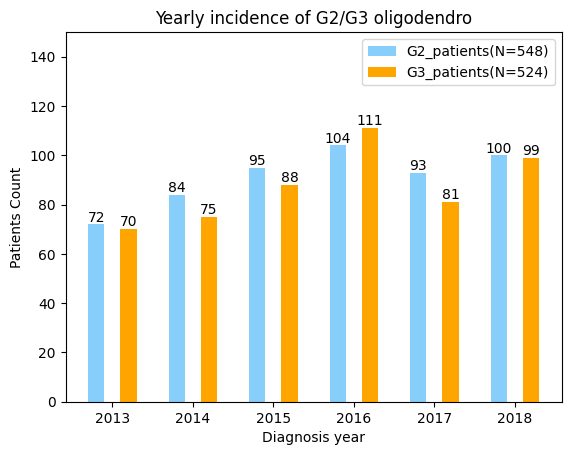

In [274]:
df_G2=df[df.GRADE=='G2']
df_G3=df[df.GRADE=='G3']

G2 = plt.bar(np.arange(len(df_G2.groupby('DIAGNOSISYEAR')['PSEUDO_PATIENTID'].nunique()))-0.2, df_G2.groupby('DIAGNOSISYEAR')['PSEUDO_PATIENTID'].nunique(), width=0.2, color='lightskyblue', label = 'G2_patients(N=548)')
G3 = plt.bar(np.arange(len(df_G3.groupby('DIAGNOSISYEAR')['PSEUDO_PATIENTID'].nunique()))+0.2, df_G3.groupby('DIAGNOSISYEAR')['PSEUDO_PATIENTID'].nunique(), width=0.2, color='orange', label = 'G3_patients(N=524)')

# build bar charts and show statistics
plt.xticks([0, 1, 2, 3, 4, 5],labels=['2013', '2014', '2015', '2016', '2017', '2018'])
plt.ylim(0,150)
plt.xlabel('Diagnosis year')
plt.ylabel('Patients Count')
plt.title('Yearly incidence of G2/G3 oligodendro')
plt.bar_label(G2)
plt.bar_label(G3)
plt.legend()


In [276]:
df_G2['PSEUDO_PATIENTID'].nunique()

548

# Treatments

In [74]:
## new version of Surgeries codes, from PHE, ICHT, GC
surgery=('A012', 'A013', 'A018', 'A019', 'A021', 'A022', 'A023', 'A024', 'A025', 'A026', 'A027', 'A028', 
         'A029', 'A073', 'A078', 'A108', 'A118', 'A168', 'A171', 'A208', 'A291', 'A293', 'A295', 'A298',
         'A381', 'A382', 'A383', 'A384', 'A385', 'A386', 'A388', 'A389', 'A428', 'A431', 'A432', 'A438',
         'A441', 'A442', 'A443', 'A444', 'A445', 'A448', 'A449', 'A511', 'A518', 'A571', 'A599', 'A611', 
         'B012', 'B068', 'C021', 'E158', 'T962', 'V031', 'V038', 'V039', 'V051', 'V058', 'V431', 'V433', 
         'V498', 'V499', 'Y059', 'Y068', 'Y069', 'Y461', 'Y463', 'Y464', 'Y465', 'Y467', 'Y468', 'Y469')

biopsy=('A041', 'A042', 'A043', 'A044', 'A045', 'A046', 'A048', 'A049', 'A081', 'A082', 'A083', 'A084', 
         'A085', 'A086', 'A088', 'A089', 'A104', 'A105', 'A181', 'A188', 'A363', 'A422', 'A454', 'A456', 
         'A481', 'A482', 'A513', 'A578', 'A731', 'B042', 'T968', 'V036', 'V052', 'Y201', 'Y202', 'Y208', 
         'Y462', 'Y466', 'Y471', 'Y472', 'Y473', 'Y474', 'Y475', 'Y476', 'Y478', 'Y479', 'Y698')

In [75]:
################## Only look at patients undergone surgeries and check their basis of diagnosis #########################
HESIP=pd.read_sql("SELECT * FROM HESAPC WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2','G3','GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (SEX IN (1,2)));",conn)

# No need to run drop duplicates here, id is the new index
# HESIP.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

HESIP=pd.merge(HESIP,df,on='PSEUDO_PATIENTID')
print('Number of oligo patients in hes apc table :')
    
print(HESIP['PSEUDO_PATIENTID'].nunique())
HESIP['id'] = HESIP.index

# reshape the dataframe to make the surgeries in one column 
HESNEW = pd.wide_to_long(HESIP,['OPERTN_','DAY_FROM_DIAG_TO_OP_'], i="id",j="column number")


Number of oligo patients in hes apc table :
1262


In [37]:
1262/1271

0.992918961447679

In [17]:
# build new index in case there is duplicates in SPEUDO_PATIENTID
# hesapc['id']=hesapc.index
# hes_all=pd.wide_to_long(hesapc, ['OPERTN_', 'DAY_FROM_DIAG_TO_OP'], i="id", j = "column number")
# hes_all.head()


In [17]:
### choose the columns we might need 
# hes_all=hes_all[['PSEUDO_PATIENTID', 'OPERTN_', 'DAY_FROM_DIAG_TO_OP', 'INTERVAL_ADMISION_DISCHARGE']]

## Note, this is for all patients instead of just oligo patients

In [119]:
### use query to get patients with surgeries and build another dataframe
# hes_all.drop_duplicates(subset='PSEUDO_PATIENTID')
# all_surgery=hes_all.query('OPERTN_ in @surgery')
# all_surgery['PSEUDO_PATIENTID'].nunique()

## Check the most popular surgeries of all patients in HESAPC table

In [120]:
# all_surgery['OPERTN_'].value_counts()

In [121]:
# A021=('A021')
# all_surgery.query('OPERTN_ in @A021')['PSEUDO_PATIENTID'].nunique()



## Surgery of oligo patients

In [76]:
## hes carry the columns that we might need
hes=HESNEW[['PSEUDO_PATIENTID', 'OPERTN_', 'DAY_FROM_DIAG_TO_OP_', 'INTERVAL_ADMISION_DISCHARGE']]

## surgery and biopsy codes came from PHE, ICHT and GC  
oligo_biopsy = hes.query('OPERTN_ in @biopsy')
oligo_surgery = hes.query('OPERTN_ in @surgery')
print('biopsy oligo:', oligo_biopsy['PSEUDO_PATIENTID'].nunique())
print('Surgery oligo:', oligo_surgery['PSEUDO_PATIENTID'].nunique())

# use concat to get patient number who had undergone surgery or biopsy
surgery_or_bio=pd.concat([oligo_surgery, oligo_biopsy])

# use merge to get patient number who had undergone surgery and biopsy
surgery_and_bio=pd.merge(oligo_surgery, oligo_biopsy, on='PSEUDO_PATIENTID')

# merge with df to ensure Site Code in C71 C72 again
df_biopsy=pd.merge(oligo_biopsy, df, on='PSEUDO_PATIENTID')
df_surgery=pd.merge(oligo_surgery, df, on='PSEUDO_PATIENTID')

surgery_or_bio=pd.merge(surgery_or_bio, df, on='PSEUDO_PATIENTID')
surgery_and_bio=pd.merge(surgery_and_bio, df, on='PSEUDO_PATIENTID')


biopsy oligo: 644
Surgery oligo: 1015


In [49]:
print('oligo patients underwent biopsies:',df_biopsy['PSEUDO_PATIENTID'].nunique())
print('biopsy participant ratio:', 644/1262)

oligo patients underwent biopsies: 644
biopsy participant ratio: 0.5103011093502378


In [50]:
print('oligo patients underwent resections',df_surgery['PSEUDO_PATIENTID'].nunique())
print('resection participant ratio:', 1015/1262)

oligo patients underwent resections 1015
resection participant ratio: 0.8042789223454834


### Number of patients who underwent a surgery or biopsy 

In [51]:
print('oligo patients underwent a surgery',surgery_or_bio['PSEUDO_PATIENTID'].nunique())
print('surgery participant ratio', 1192/1262)

oligo patients underwent a surgery 1192
surgery participant ratio 0.9445324881141046


In [52]:
print('oligo patients underwent both resections and biopsies',surgery_and_bio['PSEUDO_PATIENTID'].nunique())
print('Both participant ratio',467/1262)

oligo patients underwent both resections and biopsies 467
Both participant ratio 0.37004754358161646


## another way to define surgery dataset, no diff (N=1192)

In [417]:
# resection_or_bio=pd.concat([oligo_surgery, oligo_biopsy, surgery_and_bio])
# resection_or_bio['PSEUDO_PATIENTID'].nunique()

## Look deeper if there is any difference between different sex 

In [261]:
df_biopsy.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    335
2    309
Name: PSEUDO_PATIENTID, dtype: int64

In [262]:
df_surgery.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    534
2    481
Name: PSEUDO_PATIENTID, dtype: int64

In [263]:
surgery_and_bio.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    246
2    221
Name: PSEUDO_PATIENTID, dtype: int64

In [264]:
surgery_or_bio.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    623
2    569
Name: PSEUDO_PATIENTID, dtype: int64

## Look deeper if there is any difference between different grades

In [265]:
df_biopsy.groupby('GRADE')['PSEUDO_PATIENTID'].nunique()

GRADE
       25
G2    284
G3    271
GX     64
Name: PSEUDO_PATIENTID, dtype: int64

In [266]:
df_surgery.groupby('GRADE')['PSEUDO_PATIENTID'].nunique()

GRADE
       38
G2    435
G3    449
GX     93
Name: PSEUDO_PATIENTID, dtype: int64

In [267]:
surgery_and_bio.groupby('GRADE')['PSEUDO_PATIENTID'].nunique()

GRADE
       20
G2    190
G3    211
GX     46
Name: PSEUDO_PATIENTID, dtype: int64

In [268]:
surgery_or_bio.groupby('GRADE')['PSEUDO_PATIENTID'].nunique()

GRADE
       43
G2    529
G3    509
GX    111
Name: PSEUDO_PATIENTID, dtype: int64

# Check the most popular resections and biopsies of oligo patients

In [150]:
df_surgery['OPERTN_'].value_counts()

A021    724
A022    185
Y465    169
A023    119
Y468    119
Y469     60
A028     55
A013     44
Y467     27
V058     24
A024     22
A012     14
A108     13
A078     10
A029      8
A208      7
V039      4
A428      4
A518      4
A018      3
A611      3
V031      2
A389      2
V038      2
A388      2
A386      1
V051      1
Y068      1
A026      1
A025      1
A383      1
A027      1
Y461      1
A384      1
Name: OPERTN_, dtype: int64

In [149]:
df_biopsy['OPERTN_'].value_counts()

Y462    405
Y472    154
A081     80
A041     58
Y479     52
Y478     44
Y475     30
Y201     24
A083     24
A042     22
A082     21
A043     21
A088     11
A048      9
A049      5
Y466      5
Y698      4
A089      3
A044      3
A085      2
V036      2
Y476      2
A084      2
A045      1
A454      1
V052      1
A104      1
A046      1
Name: OPERTN_, dtype: int64

# Most oligo diagnosis were from histology, some from clinical investigation

In [207]:
grouping(surgery_or_bio, 'BASISOFDIAGNOSIS')

BASISOFDIAGNOSIS
2      13
7    1181
Name: PSEUDO_PATIENTID, dtype: int64

## Some popular surgeries for oligo patients

In [208]:
Y=('Y465')
hes.query('OPERTN_ in @Y')['PSEUDO_PATIENTID'].nunique()
# Supratentorial open approach to contents of cranium

151

In [209]:
Y468=('Y468')
hes.query('OPERTN_ in @Y468')['PSEUDO_PATIENTID'].nunique()
# Other specified open appraoach to contents of cranium

105

In [210]:
Y469=('Y469')
hes.query('OPERTN_ in @Y469')['PSEUDO_PATIENTID'].nunique()
# Unspecified open appraoach to contents of cranium

54

In [211]:
T=('A022')
hes.query('OPERTN_ in @T')['PSEUDO_PATIENTID'].nunique()
# Excision of Lesion of Tissue of Temporal Lobe

162

In [212]:
F=('A021')
hes.query('OPERTN_ in @F')['PSEUDO_PATIENTID'].nunique()
# Excision of Lesion of Tissue of Frontal Lobe

631

In [213]:
P=('A023')
hes.query('OPERTN_ in @P')['PSEUDO_PATIENTID'].nunique()
# Excision of Lesion of Tissue of Parietal Lobe

111

In [214]:
Occi=('A024')
hes.query('OPERTN_ in @Occi')['PSEUDO_PATIENTID'].nunique()
# Excision of Lesion of Tissue of Occipital Lobe

22

In [215]:
O=('A028')
hes.query('OPERTN_ in @O')['PSEUDO_PATIENTID'].nunique()
# Excision of Lesion of other Tissue of brain

54

## Survival curve of patients who underwent major resections

In [217]:
# SurvivalSITE(df_surgery, 'A021')
# SurvivalSITE(df_surgery, 'A022')
# SurvivalSITE(df_surgery, 'A023')
# SurvivalSITE(df_surgery, 'A024')
# SurvivalSITE(df_surgery, 'A028')
# plt.xlabel("days")
# plt.ylabel("Survival probability")


## Check waiting time for resection/biopsy

(0.0, 900.0)

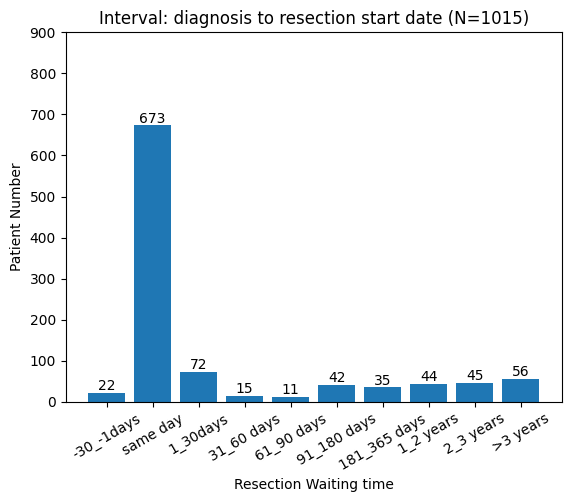

In [448]:
bin = [-31,-1, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
df_surgery.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
df_surgery['DAY_FROM_DIAG_TO_OP_'].replace(r'', np.nan, inplace = True)
df_surgery.dropna(axis=0, subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)

df_surgery['SafterD'] = pd.cut(df_surgery['DAY_FROM_DIAG_TO_OP_'].astype(float).astype(int), bins = bin, labels=('<-30days','-29_0days','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'))
df_surgery.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(df_surgery.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())), df_surgery.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],rotation=30,labels=['-30_-1days','same day','1_30days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('Resection Waiting time')
plt.ylabel('Patient Number')
plt.title('Interval: diagnosis to resection start date (N=1015)')
plt.ylim(0,900)

In [442]:
sd_sameday=df_surgery[df_surgery['DAY_FROM_DIAG_TO_OP_']==0]
sd_sameday['PSEUDO_PATIENTID'].nunique()

673

(0.0, 600.0)

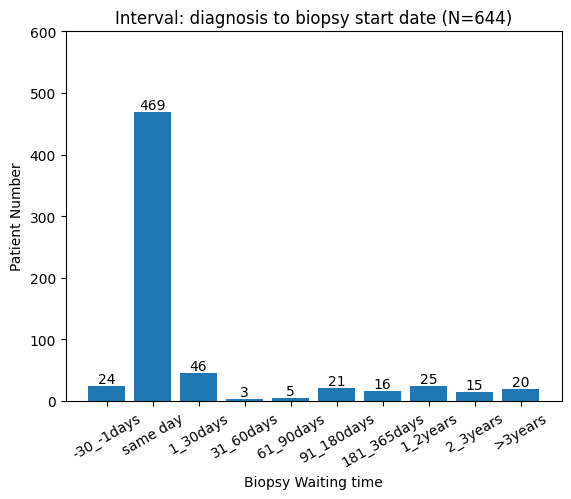

In [449]:
bin = [-31,-1, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
df_biopsy.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
df_biopsy['DAY_FROM_DIAG_TO_OP_'].replace(r'', np.nan, inplace = True)
df_biopsy.dropna(axis=0, subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)

df_biopsy['SafterD'] = pd.cut(df_biopsy['DAY_FROM_DIAG_TO_OP_'].astype(float).astype(int), bins = bin, labels=('_-30days','-29_0days','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'))
df_biopsy.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(df_biopsy.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())), df_biopsy.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],rotation=30,labels=['-30_-1days','same day','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'])
plt.bar_label(BAR)
plt.xlabel('Biopsy Waiting time')
plt.ylabel('Patient Number')
plt.title('Interval: diagnosis to biopsy start date (N=644)')
plt.ylim(0,600)

(0.0, 900.0)

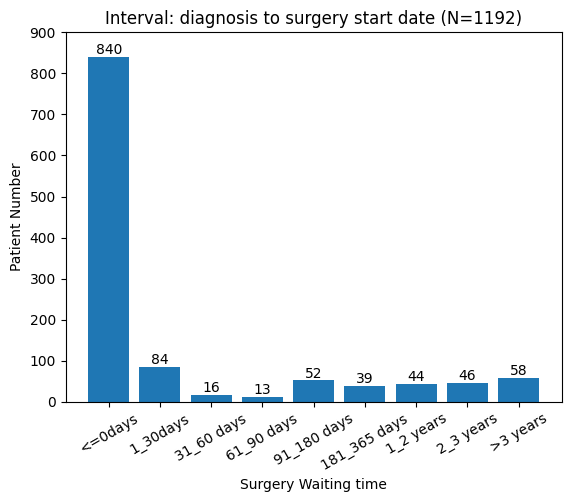

In [457]:
bin = [-31, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
surgery_or_bio.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
surgery_or_bio['DAY_FROM_DIAG_TO_OP_'].replace(r'', np.nan, inplace = True)
surgery_or_bio.dropna(axis=0, subset=['DAY_FROM_DIAG_TO_OP_'], inplace=True)

surgery_or_bio['SafterD'] = pd.cut(surgery_or_bio['DAY_FROM_DIAG_TO_OP_'].astype(float).astype(int), bins = bin, labels=('-29_0days','1_30days', '31_60days', '61_90days', '91_180days', '181_365days', '1_2years', '2_3years', '>3years'))
surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())), surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=30,labels=['<=0days','1_30days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('Surgery Waiting time')
plt.ylabel('Patient Number')
plt.title('Interval: diagnosis to surgery start date (N=1192)')
plt.ylim(0,900)

In [456]:
surgery_or_bio['PSEUDO_PATIENTID'].nunique()

1192

# Overall survival curve of oligo patients

365     0.911094
730     0.857860
1095    0.805282
1460    0.771031
1825    0.725953
Name: oligo patients, dtype: float64
Median survival time :  inf


Text(0, 0.5, 'Survival Probability')

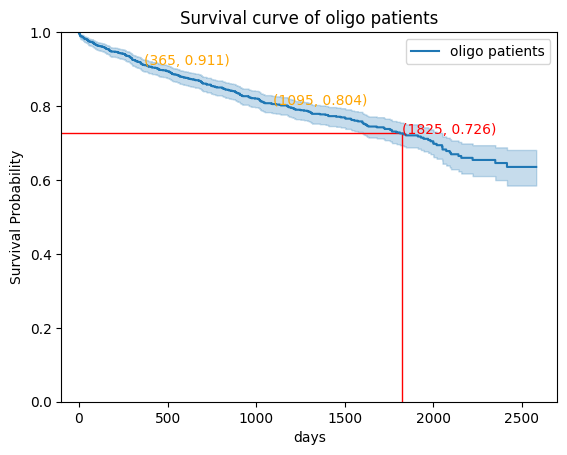

In [277]:
kmf = KaplanMeierFitter()
## drop NA
df['VITALSTATUS_NEW'] = df.apply(conditions, axis=1)
kmf.fit(durations = df['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df['VITALSTATUS_NEW'], label = 'oligo patients')
# limit for later cordinates' showing
plt.xlim(-100, 2700)

## print 1,23,4,5 years' survival rates
print(kmf.survival_function_at_times([365, 730, 1095, 1460, 1825]))

## Show cordinates of special points
plt.text(365, 0.911, (365, 0.911), color='orange')
plt.text(1095, 0.804, (1095, 0.804), color='orange')
plt.text(1825, 0.726, (1825, 0.726), color='red')
plt.axvline(x=1825,ymin=0, ymax=0.726, color='red', lw=1)
plt.axhline(y=0.726,xmin=0, xmax=0.6875,color='red', lw=1)

kmf.plot(title='Survival curve of oligo patients')
print('Median survival time', ': ', kmf.median_survival_time_)
plt.ylim(0,1)
plt.xlabel("days")
plt.ylabel("Survival Probability")
#######################################################################################################################
########### IF S(t_final) > 0.5, the median survival time can't be estimated, so it just shows inf ###################
##########################################################################################################################

## Generate the risk table seperately

(0.0, 1.0)

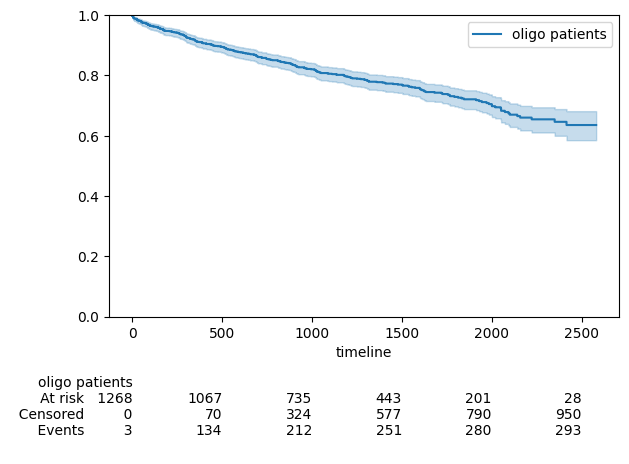

In [278]:
kmf.plot_survival_function(at_risk_counts=True)
plt.ylim(0,1)

# Cox model on main cohort

In [279]:
## firstly we need to deal with NA in GRADE
df['GRADE'].replace('','GX', inplace=True)
df['GRADE'].replace('GX','NOS', inplace=True)
df.groupby('GRADE')['PSEUDO_PATIENTID'].nunique()

GRADE
G2     548
G3     524
NOS    199
Name: PSEUDO_PATIENTID, dtype: int64

## Data cleaning and get dummies

In [293]:
# SELECT THE COLUMNS that we need 
df_cox=df[['AGE', 'SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE', 'VITALSTATUS', 'INTERVAL_DIAG_TO_VS', 'SITE_ICD10_O2']]


## ETHNICITY, SITE_ICD, INCOME into larger classification

In [294]:
##### A,D in VITALSTATUS should be binarized, and patients with ethnicity less than 10 and 'NOT STATED' were all incorperated into other

df_cox['VITALSTATUS'].replace(r'A', 1, inplace=True)
df_cox['VITALSTATUS'].replace(r'D', 0, inplace=True)

## black, asian, white and NOS
df_cox['ETHNICITYNAME'].replace('ANY OTHER BLACK BACKGROUND', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK AFRICAN', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK CARIBBEAN', 'BLACK', inplace=True)

df_cox['ETHNICITYNAME'].replace('CHINESE', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN INDIAN', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN PAKISTANI', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ASIAN BACKGROUND', 'ASIAN', inplace=True)

df_cox['ETHNICITYNAME'].replace('WHITE IRISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('WHITE BRITISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER WHITE BACKGROUND', 'WHITE', inplace=True)

df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT KNOWN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT STATED', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ETHNIC GROUP', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND ASIAN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND BLACK CARIBBEAN', 'Ethnicity NOS', inplace=True)

## C71 and C72
df_cox['SITE_ICD10_O2'].replace('C725', 'C72', inplace=True)

df_cox['SITE_ICD10_O2'].replace('C710', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C711', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C712', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C713', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C714', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C716', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C718', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C719', 'C71', inplace=True)

## Most/middle/Least deprived
df_cox['INCOME_QUINTILE_2015'].replace('1 - Least deprived', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('2', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('3', 'Middle deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('4', 'Most deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('5 - Most deprived', 'Most deprived', inplace=True)


/tmp/ipykernel_778728/1651822997.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/1651822997.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/1651822997.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/1651822997.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [295]:
df_cox=pd.get_dummies(df_cox, columns=['SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE', 'SITE_ICD10_O2'])


## Model summary

In [334]:
#### Assumpation: all covariates' hazrd doesn't changed with time passing by
cph=CoxPHFitter(l1_ratio=0.9, penalizer=1)
### default l1_ratio=0, means we dont need l2 regulation for feature selection
cph.fit(df_cox, "INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS", show_progress=False)
cph.print_summary()

# z == wald test, indicates the significance of covariate
# coef == coefficients
# exp(coef) == hazard ratio, indicates the effect size of covariate

<lifelines.CoxPHFitter: fitted with 1271 total observations, 293 right-censored observations>
             duration col = 'INTERVAL_DIAG_TO_VS'
                event col = 'VITALSTATUS'
                penalizer = 1
                 l1 ratio = 0.9
      baseline estimation = breslow
   number of observations = 1271
number of events observed = 978
   partial log-likelihood = -5854.60
         time fit was run = 2023-01-08 03:41:36 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
AGE                                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SEX_1                                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SEX_2                                 -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
INCOME_QUINTILE_2015_Least deprived    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
INCOME_QUINTILE_2015_Middle deprived   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
INCOME_QUINTILE_2015_Most deprived    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ETHNICITYNAME_ASIAN                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ETHNICITYNAME_BLACK                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ETHNICITYNAME_Ethnicity NOS            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ETHNICITYNAME_WHITE                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
GRADE_G2                              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
GRADE_G3                               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
GRADE_NOS                             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SITE_ICD10_O2_C71                      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SITE_ICD10_O2_C72                     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                       cmp to     z    p   -log2(p)
covariate                                                          
AGE                                      0.00 -0.00 1.00       0.00
SEX_1                                    0.00  0.00 1.00       0.00
SEX_2                                    0.00 -0.00 1.00       0.00
INCOME_QUINTILE_2015_Least deprived      0.00  0.00 1.00       0.00
INCOME_QUINTILE_2015_Middle deprived     0.00  0.00 1.00       0.00
INCOME_QUINTILE_2015_Most deprived       0.00 -0.00 1.00       0.00
ETHNICITYNAME_ASIAN                      0.00  0.00 1.00       0.00
ETHNICITYNAME_BLACK                      0.00  0.00 1.00       0.00
ETHNICITYNAME_Ethnicity NOS              0.00  0.00 1.00       0.00
ETHNICITYNAME_WHITE                      0.00 -0.00 1.00       0.00
GRADE_G2                                 0.00 -0.00 1.00       0.00
GRADE_G3                                 0.00  0.00 1.00       0.00
GRADE_NOS                                0.00 -0.00 1.00       0.00
SITE_ICD10_O2_C71                        0.00  0.00 1.00       0.00
SITE_ICD10_O2_C72                        0.00 -0.00 1.

In [130]:
# cph.variance_matrix_

In [358]:
cph.predict_survival_function(df_cox)

0         1         2         3         4         5         6     \
0.0     0.996890  0.998909  0.998221  0.998805  0.996636  0.998959  0.999378   
1.0     0.995852  0.998544  0.997627  0.998406  0.995514  0.998611  0.999170   
2.0     0.994815  0.998179  0.997033  0.998007  0.994393  0.998263  0.998962   
4.0     0.990674  0.996721  0.994658  0.996411  0.989917  0.996872  0.998130   
5.0     0.989638  0.996355  0.994063  0.996011  0.988797  0.996523  0.997922   
...          ...       ...       ...       ...       ...       ...       ...   
2564.0  0.485528  0.776254  0.661635  0.757872  0.457723  0.785369  0.865607   
2568.0  0.485528  0.776254  0.661635  0.757872  0.457723  0.785369  0.865607   
2570.0  0.485528  0.776254  0.661635  0.757872  0.457723  0.785369  0.865607   
2571.0  0.485528  0.776254  0.661635  0.757872  0.457723  0.785369  0.865607   
2581.0  0.485528  0.776254  0.661635  0.757872  0.457723  0.785369  0.865607   

            7         8         9     ...      1277      1278      1279  \
0.0     0.999586  0.998594  0.998051  ...  0.999321  0.997631  0.998359   
1.0     0.999447  0.998125  0.997401  ...  0.999094  0.996841  0.997811   
2.0     0.999309  0.997655  0.996750  ...  0.998867  0.996050  0.997263   
4.0     0.998754  0.995778  0.994150  ...  0.997958  0.992893  0.995072   
5.0     0.998615  0.995307  0.993499  ...  0.997731  0.992102  0.994523   
...          ...       ...       ...  ...       ...       ...       ...   
2564.0  0.908359  0.721602  0.636076  ...  0.854198  0.576920  0.683218   
2568.0  0.908359  0.721602  0.636076  ...  0.854198  0.576920  0.683218   
2570.0  0.908359  0.721602  0.636076  ...  0.854198  0.576920  0.683218   
2571.0  0.908359  0.721602  0.636076  ...  0.854198  0.576920  0.683218   
2581.0  0.908359  0.721602  0.636076  ...  0.854198  0.576920  0.683218   

            1280      1281      1282      1283      1284      1285      1286  
0.0     0.996298  0.997935  0.997374  0.998568  0.998333  0.999505  0.998837  
1.0     0.995064  0.997246  0.996498  0.998090  0.997777  0.999339  0.998448  
2.0     0.993830  0.996557  0.995622  0.997612  0.997220  0.999174  0.998059  
4.0     0.988907  0.993803  0.992124  0.995700  0.994995  0.998511  0.996505  
5.0     0.987675  0.993113  0.991248  0.995220  0.994438  0.998345  0.996116  
...          ...       ...       ...       ...       ...       ...       ...  
2564.0  0.423063  0.619163  0.543471  0.717238  0.679142  0.891468  0.763403  
2568.0  0.423063  0.619163  0.543471  0.717238  0.679142  0.891468  0.763403  
2570.0  0.423063  0.619163  0.543471  0.717238  0.679142  0.891468  0.763403  
2571.0  0.423063  0.619163  0.543471  0.717238  0.679142  0.891468  0.763403  
2581.0  0.423063  0.619163  0.543471  0.717238  0.679142  0.891468  0.763403  

[990 rows x 1287 columns]

In [298]:
cph.check_assumptions(df_cox)

Proportional hazard assumption looks okay.


[]

## if we want to know the effect of increasing penalizer value on the resulting coefficients in cox model with L1 ratio == 0

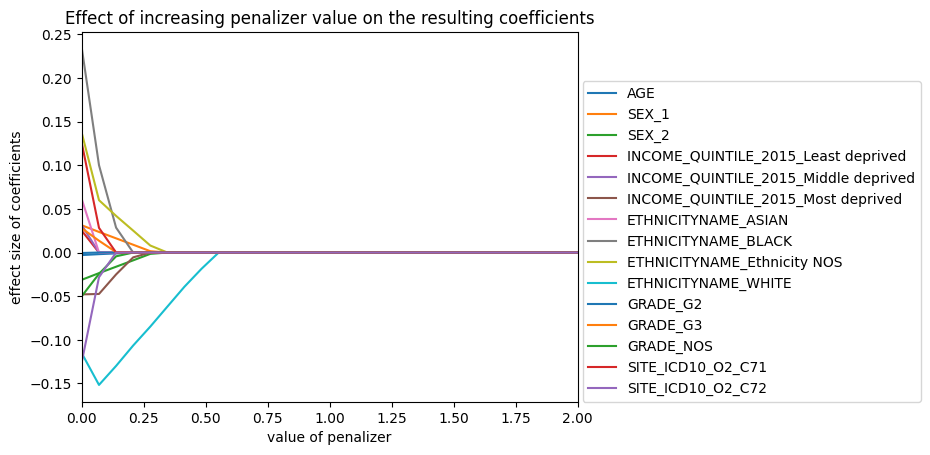

In [317]:
results={}
for p in np.linspace(0.001, 1, 30):
    cph_plus=CoxPHFitter(l1_ratio=0.9, penalizer=p).fit(df_cox, "INTERVAL_DIAG_TO_VS", "VITALSTATUS")
    results[p] = cph_plus.params_
    
pd.DataFrame(results).T.plot()
plt.xlim(0, 1)
plt.title('Effect of increasing penalizer value on the resulting coefficients')
plt.xlabel('value of penalizer')
plt.ylabel('effect size of coefficients')
plt.legend(bbox_to_anchor=(1.01,0), loc=3, borderaxespad=0)

## set the l1_ratio first, and check which penalizer value is better

In [123]:
# results={}
# for p in np.linspace(0.001, 1, 50):
#     cph_plus=CoxPHFitter(l1_ratio=0.2, penalizer=p).fit(df_cox, "INTERVAL_DIAG_TO_VS", "VITALSTATUS")
#     results[p] = cph_plus.params_
    
# pd.DataFrame(results).T.plot()
# plt.xlim(0, 1)
# plt.legend(bbox_to_anchor=(1.01,0), loc=3, borderaxespad=0, fontsize=5)

## Model plot -- Concordance Test

Text(0.5, 1.0, 'Covariates log(HR)')

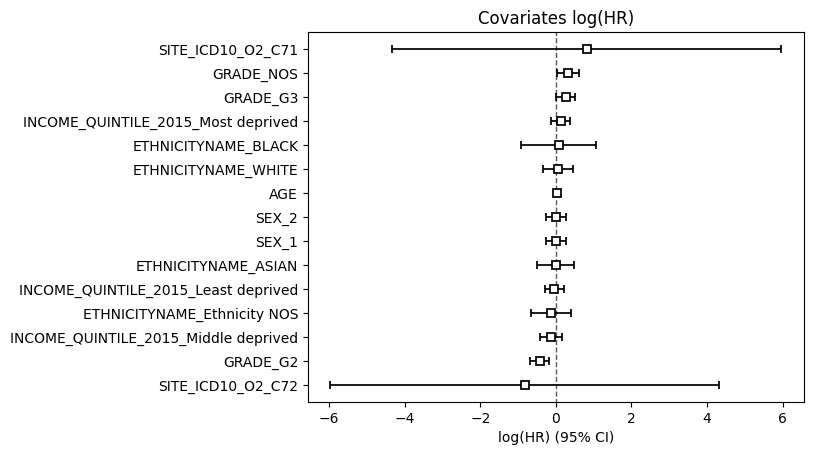

In [119]:
cph.plot()
plt.title('Covariates log(HR)')
# plt.yticks(fontsize=7)

In [276]:
# cph.predict_partial_hazard(df_cox)
# Each patients' survival hazrd

## Investigate how single covariate influent the model

Text(0.5, 1.0, 'survival Probability for AGE Points')

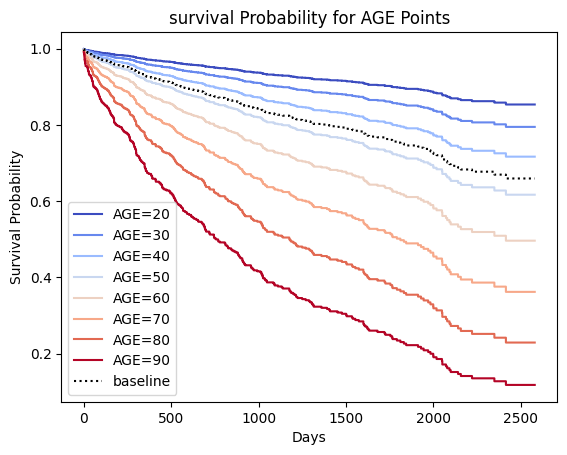

In [120]:
cph.plot_covariate_groups(covariates='AGE', values=[20,30,40,50,60,70,80,90], plot_baseline=True, cmap='coolwarm')
plt.ylabel('Survival Probability')
plt.xlabel('Days')
plt.title('survival Probability for AGE Points')

In [5]:
# cph.plot_covariate_groups(covariates='INCOME_QUINTILE_2015', values=[1,2,3,4,5], plot_baseline=True, cmap='coolwarm')
# plt.ylabel('Survival Probability')
# plt.xlabel('Days')
# plt.title('survival Probability for income groups')
# plt.ylim(0.5,1)

In [274]:
# cph.plot_covariate_groups(covariates='SITE_ICD10_O2', values=[10,11,12,13,14,16,18,19,25], plot_baseline=True, cmap='coolwarm')
# plt.ylabel('Survival Probability')
# plt.xlabel('Days')
# plt.title('survival risk for tumour site groups')
# plt.ylim(0.5,1)

# 710== cerebrum
# 711== Frontal lobe
# 712== Temporal lobe
# 713== Parietal lobe
# 714= Occipital lobe
# 716== cerebellum
# 718== Overlapping lesion of brain
# 719== Brain, unspecified
# 725== cranial nerves


In [275]:
# cph.plot_covariate_groups(covariates='GRADE', values=[2,3], plot_baseline=True, cmap='coolwarm')
# plt.ylabel('Survival Probability')
# plt.xlabel('Days')
# plt.title('survival risk for Grades')

## Survival curve by age

/tmp/ipykernel_641545/684434533.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



365     0.969950
730     0.946353
1095    0.925650
1460    0.898687
1825    0.853757
Name: 18_44, dtype: float64


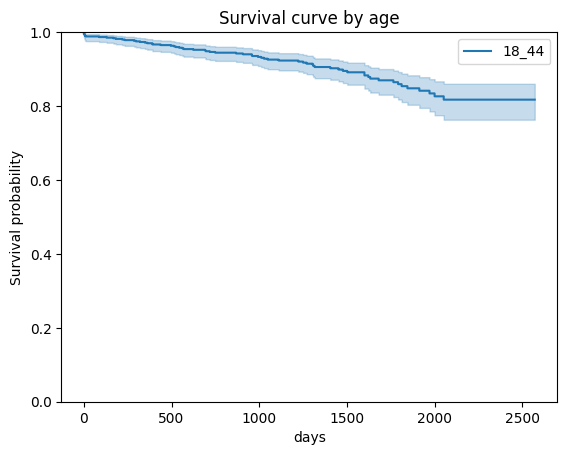

In [43]:
############################ To check survival rate in different age groups #########################################
df.loc[(17 < df.AGE) & (df.AGE < 45), 'Agroup'] = '18_44' # 
df.loc[(44 < df.AGE) & (df.AGE < 70), 'Agroup'] = '45_69' # 
df.loc[(69 < df.AGE) & (df.AGE < 100), 'Agroup'] = '70_99' # (70, 105], max age for oligo in TUM_PAT is 99

SurvivalAGE(df, '18_44')

/tmp/ipykernel_778728/684434533.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



365     0.900697
730     0.822659
1095    0.748727
1460    0.709761
1825    0.670134
Name: 45_69, dtype: float64


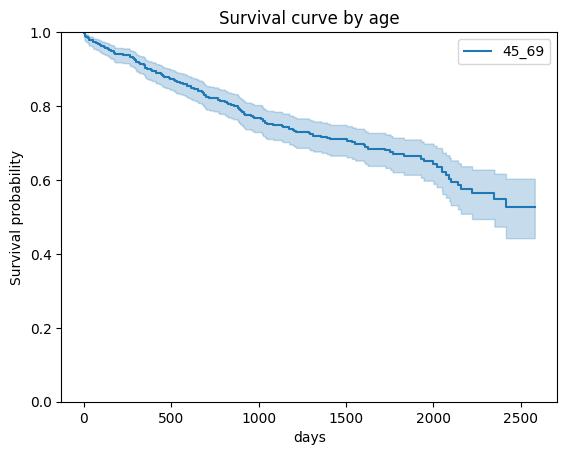

In [335]:
SurvivalAGE(df, '45_69')

/tmp/ipykernel_778728/684434533.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



365     0.612245
730     0.520987
1095    0.393962
1460    0.342576
1825    0.263783
Name: 70_99, dtype: float64


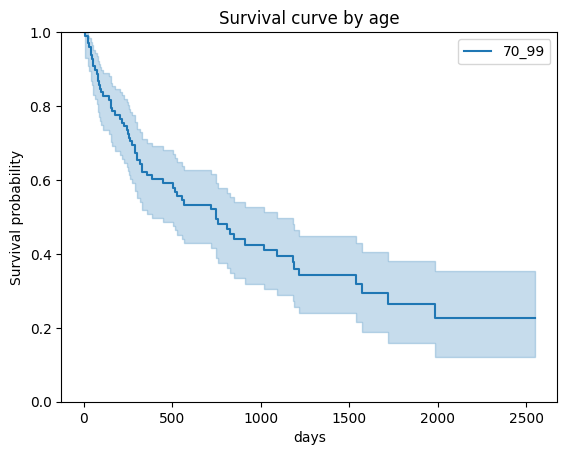

In [337]:
SurvivalAGE(df, '70_99')

### oligo is still very deadly for elder patients

/tmp/ipykernel_641545/2319092110.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/2319092110.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_641545/2319092110.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Survival Curve by age groups')

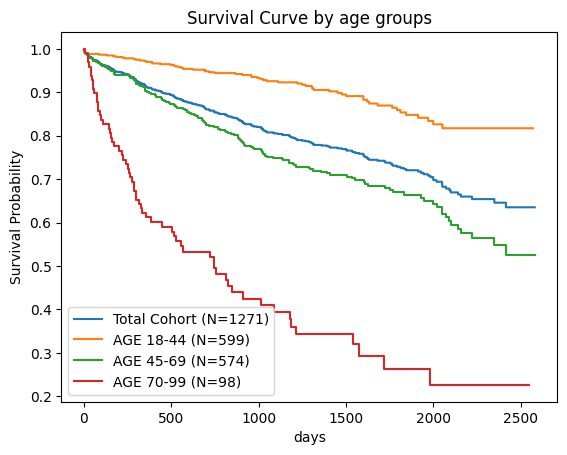

In [45]:
# SurvivalAGE(df, '18_44')
# SurvivalAGE(df, '45_69')
# SurvivalAGE(df, '70_99')

young=('18_44')
middle=('45_69')
old=('70_99')

df_18_44 = df.query('Agroup in @young') 
df_45_69 = df.query('Agroup in @middle')
df_70_99 = df.query('Agroup in @old')

df['VITALSTATUS_NEW'] = df.apply(conditions, axis=1)
A=kmf.fit(durations = df['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df['VITALSTATUS_NEW'], label = 'Total Cohort (N=1271)')
kmf.plot(ci_show=False)

df_18_44['VITALSTATUS_NEW'] = df_18_44.apply(conditions, axis = 1)
B=kmf.fit(durations = df_18_44['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_18_44['VITALSTATUS_NEW'], label = 'AGE 18-44 (N=599)')
kmf.plot(ci_show=False)

df_45_69['VITALSTATUS_NEW'] = df_45_69.apply(conditions, axis = 1)
C=kmf.fit(durations = df_45_69['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_45_69['VITALSTATUS_NEW'], label = 'AGE 45-69 (N=574)')
kmf.plot(ci_show=False)

df_70_99['VITALSTATUS_NEW'] = df_70_99.apply(conditions, axis = 1)
D=kmf.fit(durations = df_70_99['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_70_99['VITALSTATUS_NEW'], label = 'AGE 70-99 (N=98)')
kmf.plot(ci_show=False)
plt.ylabel('Survival Probability')
plt.xlabel('days')
plt.title('Survival Curve by age groups')


In [341]:
## each groups' count
df.groupby('Agroup')['PSEUDO_PATIENTID'].nunique()

Agroup
18_44    599
45_69    574
70_99     98
Name: PSEUDO_PATIENTID, dtype: int64

## log_rank test on young and middle age group, significant

In [342]:
# Pairwaise comparison  
y_m_results = logrank_test(df_18_44['INTERVAL_DIAG_TO_VS'], df_45_69['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = df_18_44.apply(conditions,axis=1).astype(int),
                       event_observed_B = df_45_69.apply(conditions,axis=1).astype(int))
y_m_results.print_summary()
# Very significant difference

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          64.11 <0.005     49.59

## log_rank test on middle and elder age group, significant

In [343]:
m_o_results = logrank_test(df_45_69['INTERVAL_DIAG_TO_VS'], df_70_99['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = df_45_69.apply(conditions,axis=1).astype(int),
                       event_observed_B = df_70_99.apply(conditions,axis=1).astype(int))
m_o_results.print_summary()
# actually very obvious on the graph 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          74.39 <0.005     57.11

Median survival male :  inf


/tmp/ipykernel_778728/401605800.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



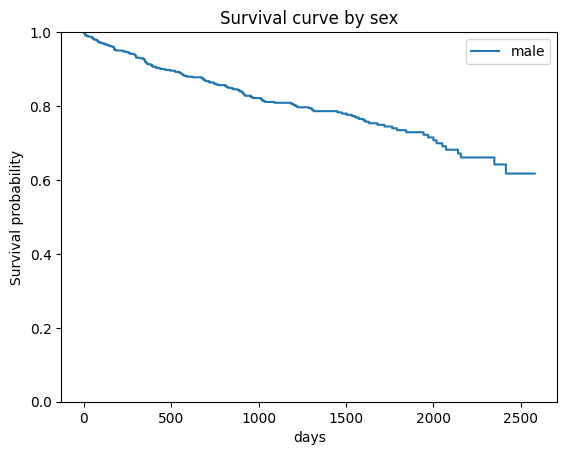

In [344]:
# df.loc[df.SEX==1, 'Sgroup'] = 'male' 
# df.loc[df.SEX==2, 'Sgroup'] = 'female' 

# SurvivalSEX(df, 'male')
# inf is due to the that that number s too large

/tmp/ipykernel_489130/1543416679.py:76: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Median survival female :  inf


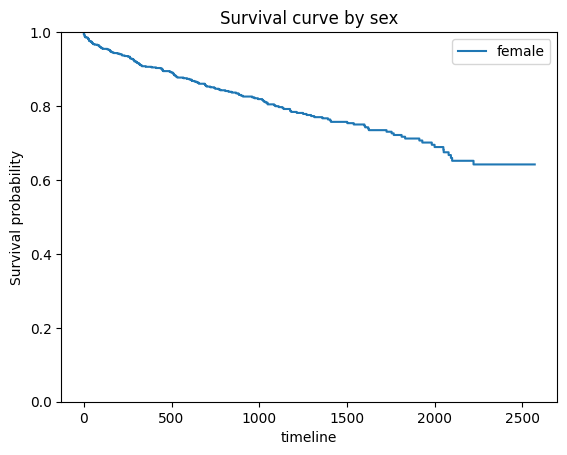

In [185]:
# SurvivalSEX(df, 'female')
# FEMALE survival rate is higher

In [474]:
# SurvivalSEX(df, 'male')
# SurvivalSEX(df, 'female')
   
# results = logrank_test(df_male['INTERVAL_DIAG_TO_VS'].astype(int), df_female['INTERVAL_DIAG_TO_VS'].astype(int),
#                        event_observed_A = df_male.apply(conditions,axis=1).astype(int),
#                        event_observed_B = df_female.apply(conditions,axis=1).astype(int))
# results.print_summary()

## no significant differrence found between diff SEX, then INCOME

In [347]:
# JUST curious, no article about it found yet
    
# df.loc[df.INCOME_QUINTILE_2015=='5 - Most deprived', 'Igroup'] = '5_Most_deprived' 
# df.loc[df.INCOME_QUINTILE_2015=='4', 'Igroup'] = '4'     
# df.loc[df.INCOME_QUINTILE_2015=='3', 'Igroup'] = '3'     
# df.loc[df.INCOME_QUINTILE_2015=='2', 'Igroup'] = '2' 
# df.loc[df.INCOME_QUINTILE_2015=='1 - Least deprived', 'Igroup'] = '1_Least_deprived' 

# SurvivalINCOME(df, '1_Least_deprived')

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

In [ ]:
SurvivalINCOME(df, '2')

In [ ]:
SurvivalINCOME(df, '3')

/tmp/ipykernel_1579229/3374858692.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Median survival 4 :  inf


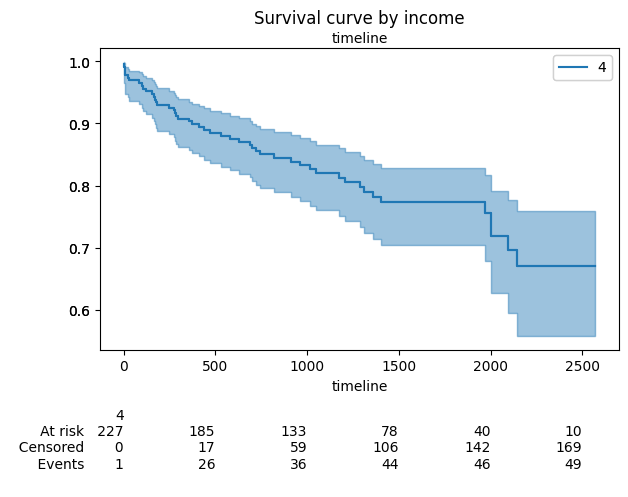

In [167]:
SurvivalINCOME(df, '4')

/tmp/ipykernel_1579229/3374858692.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Median survival 5_Most_deprived :  inf


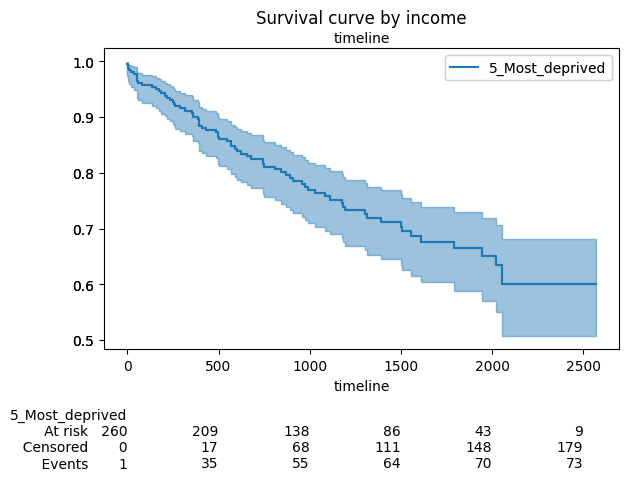

In [168]:
SurvivalINCOME(df, '5_Most_deprived')
# it just follows no rules, 1 and 5 got similar survival rates, 4 got the highest survival rate

## INCOME_QUINTILE 3 and 4 patients got the best survivals

In [346]:
SurvivalINCOME(df, '1_Least_deprived')
SurvivalINCOME(df, '2')
SurvivalINCOME(df, '3')
SurvivalINCOME(df, '4')
SurvivalINCOME(df, '5_Most_deprived')


ValueError: Values must be numeric: no strings, datetimes, objects, etc.

365     0.968978
730     0.938798
1095    0.917208
1460    0.891419
1825    0.839704
Name: G2, dtype: float64
365     0.881679
730     0.803424
1095    0.722993
1460    0.679551
1825    0.630999
Name: G3, dtype: float64


/tmp/ipykernel_778728/401605800.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/401605800.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          58.97 <0.005     45.83

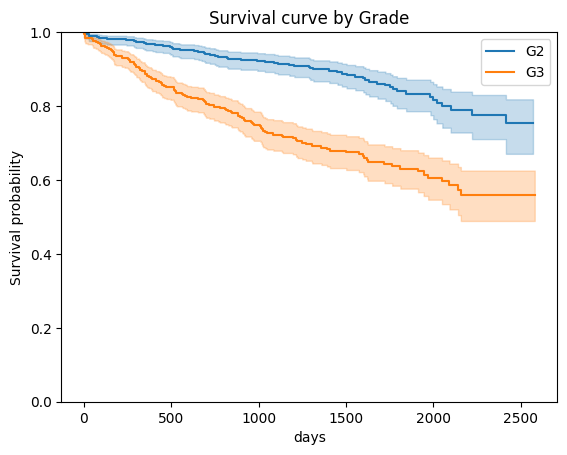

In [351]:
SurvivalGrade(df,'G2')
SurvivalGrade(df,'G3')

## BUILD df for G2/3
df_G2=df[df.GRADE=='G2']
df_G3=df[df.GRADE=='G3']

results = logrank_test(df_G2['INTERVAL_DIAG_TO_VS'].astype(int), df_G3['INTERVAL_DIAG_TO_VS'].astype(int),
                       event_observed_A = df_G2.apply(conditions,axis=1).astype(int),
                       event_observed_B = df_G3.apply(conditions,axis=1).astype(int))
results.print_summary()

In [349]:
df_G2['PSEUDO_PATIENTID'].nunique()

548

In [350]:
df_G3['PSEUDO_PATIENTID'].nunique()

524

## Survival by Tumour sites

In [361]:
## data amount less than 10 groups were removed, Cerebellum N==1, Spinal cord N==1, Cranial nerves N==1
df_710=df[df.SITE_ICD10_O2=='C710']
df_711=df[df.SITE_ICD10_O2=='C711']
df_712=df[df.SITE_ICD10_O2=='C712']
df_713=df[df.SITE_ICD10_O2=='C713']
df_714=df[df.SITE_ICD10_O2=='C714']
df_718=df[df.SITE_ICD10_O2=='C718']
df_719=df[df.SITE_ICD10_O2=='C719']

# print(df_718['PSEUDO_PATIENTID'].nunique())


29


365     0.891304
730     0.844394
1095    0.815277
1460    0.815277
1825    0.815277
Name: Cerebrum(N=46), dtype: float64
365     0.931601
730     0.894420
1095    0.836757
1460    0.801663
1825    0.749076
Name: Frontal Lobe(N=731), dtype: float64
365     0.907609
730     0.782087
1095    0.722993
1460    0.673907
1825    0.673907
Name: Temporal Lobe(N=184), dtype: float64
365     0.892086
730     0.839538
1095    0.791030
1460    0.754616
1825    0.716739
Name: Parietal Lobe(N=139), dtype: float64
365     0.909091
730     0.818182
1095    0.770053
1460    0.721925
1825    0.577540
Name: Occipital Lobe(N=29), dtype: float64
365     0.931034
730     0.931034
1095    0.884483
1460    0.835345
1825    0.771088
Name: Overlapping lesion of Brain Lobe(N=29), dtype: float64
365     0.813559
730     0.769368
1095    0.737873
1460    0.726344
1825    0.682508
Name: Brain, unspecified(N=118), dtype: float64


/tmp/ipykernel_778728/1106335060.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/1106335060.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/1106335060.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykern

(0.0, 1.0)

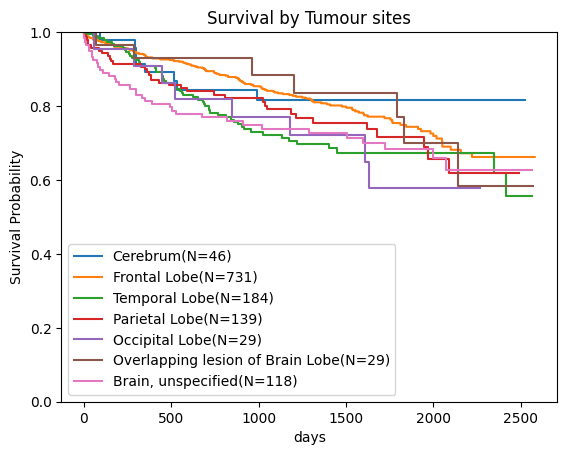

In [362]:
df_710['VITALSTATUS_NEW'] = df_710.apply(conditions, axis = 1)
kmf.fit(durations = df_710['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_710['VITALSTATUS_NEW'].astype(int), label = 'Cerebrum(N=46)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))

df_711['VITALSTATUS_NEW'] = df_711.apply(conditions, axis = 1)
kmf.fit(durations = df_711['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_711['VITALSTATUS_NEW'].astype(int), label = 'Frontal Lobe(N=731)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))

df_712['VITALSTATUS_NEW'] = df_712.apply(conditions, axis = 1)
kmf.fit(durations = df_712['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_712['VITALSTATUS_NEW'].astype(int), label = 'Temporal Lobe(N=184)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))

df_713['VITALSTATUS_NEW'] = df_713.apply(conditions, axis = 1)
kmf.fit(durations = df_713['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_713['VITALSTATUS_NEW'].astype(int), label = 'Parietal Lobe(N=139)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))

df_714['VITALSTATUS_NEW'] = df_714.apply(conditions, axis = 1)
kmf.fit(durations = df_714['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_714['VITALSTATUS_NEW'].astype(int), label = 'Occipital Lobe(N=29)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))

df_718['VITALSTATUS_NEW'] = df_718.apply(conditions, axis = 1)
kmf.fit(durations = df_718['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_718['VITALSTATUS_NEW'].astype(int), label = 'Overlapping lesion of Brain Lobe(N=29)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))


df_719['VITALSTATUS_NEW'] = df_719.apply(conditions, axis = 1)
kmf.fit(durations = df_719['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = df_719['VITALSTATUS_NEW'].astype(int), label = 'Brain, unspecified(N=118)')
kmf.plot(ci_show=False)
print(kmf.survival_function_at_times([365, 730, 1095,1460,1825]))

plt.title('Survival by Tumour sites')
plt.ylabel('Survival Probability')
plt.xlabel('days')
plt.ylim(0,1)


## Survival part end, now RTDS

In [153]:
##################### FOCUS ON fraction and does in RTDS table ####################################
radio_oligo = pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) );",conn)
print('Total number of patients with oligodendro in RTDS table:', radio_oligo['PSEUDO_PATIENTID'].nunique())
radio_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)


Total number of patients with oligodendro in RTDS table: 823


### oligo could grow on C70 and C72, but we dont have record of C70

In [154]:
######################## Fetch the first 3 characters to get Primary diagnosis start with C71 C72 ###############

radio_oligo['PRIMARYDIAGNOSISICD']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str)
radio_oligo['ICD10']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# Creating a dataframe that locks from the original dataframe the patient id and the new ICD10 column
radio_P=radio_oligo[['PSEUDO_PATIENTID','ICD10', 'RTTREATMENTREGION', 'RTPRESCRIBEDDOSE','ACTUALFRACTIONS', 'RTACTUALDOSE','INTERVAL_DIAG_TO_TREAT_START']]

rtds2=pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX', '')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) );",conn)
rtds2['PRIMARYDIAGNOSISICD']=rtds2['PRIMARYDIAGNOSISICD'].astype(str)
rtds2['ICD10']=rtds2['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# Creating three dataframes capturing the patients with different ICD10 codes for brain tumours in each 
rtdsnew=radio_P.loc[(radio_P['ICD10'] == 'C71')]
rtds2new=rtds2.loc[(rtds2['ICD10'] == 'C72' )]

# combining the three dataframes 
rtds=pd.concat([rtdsnew, rtds2new])
print('Number of patients that had an ICD 10 code of C71 or C72:', rtds['PSEUDO_PATIENTID'].nunique())

print('Number of patients without a brain tumour diagnosis in RTDS:', radio_oligo['PSEUDO_PATIENTID'].nunique() - rtds['PSEUDO_PATIENTID'].nunique())


Number of patients that had an ICD 10 code of C71 or C72: 791
Number of patients without a brain tumour diagnosis in RTDS: 32


In [155]:
# Substracting patients that were not treated for their primary diagnosis
region=rtds[['PSEUDO_PATIENTID','RTTREATMENTREGION', 'INTERVAL_DIAG_TO_TREAT_START', 'ACTUALFRACTIONS', 'RTACTUALDOSE', 'RTPRESCRIBEDDOSE']]
region=region.drop_duplicates()
a=(region['PSEUDO_PATIENTID'].nunique())
print('Total number of oligo patients with a brain tumour diagnosis in RTDS:', a)

# Creating a list with the values of the variable (region of treatment) that we want to get numbers for
primary=('P', 'R', 'PR')
# Creating a dataframe that retains only the rows with the values we selected before in the list
prim=region[region.RTTREATMENTREGION.isin(primary)]
# Printing the  number of patients assigned those selected treatments
print(prim['RTTREATMENTREGION'].value_counts())
print('Number of patients with a brain tumour diagnosis in RTDS receiving treatment to their primary site:', prim['PSEUDO_PATIENTID'].nunique())

Total number of oligo patients with a brain tumour diagnosis in RTDS: 791
P     760
PR      1
Name: RTTREATMENTREGION, dtype: int64
Number of patients with a brain tumour diagnosis in RTDS receiving treatment to their primary site: 760


In [156]:
# reassignment: from RTDS patients who had ICD10 code of C70 C71 and C72, and received treatment to their primary sites
r_oligo=prim
r_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
r_oligo['PSEUDO_PATIENTID'].nunique()

/tmp/ipykernel_3587902/3793976419.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



760

## Combine cleaned rtds data with data in TUM_PAT

In [157]:
r_oligo=pd.merge(r_oligo, df, on='PSEUDO_PATIENTID')

In [158]:
r_oligo['PSEUDO_PATIENTID'].nunique()

749

In [159]:
r_oligo['RTPRESCRIBEDDOSE'].replace(r'',np.nan,inplace=True)
r_oligo.dropna(subset='RTPRESCRIBEDDOSE', inplace=True)
print(r_oligo['PSEUDO_PATIENTID'].nunique())

748


In [160]:
r_oligo['RTACTUALDOSE'].replace(r'',np.nan,inplace=True)
r_oligo.dropna(subset='RTACTUALDOSE', inplace=True)
print(r_oligo['PSEUDO_PATIENTID'].nunique())

475


In [161]:
r_oligo['ACTUALFRACTIONS'].replace(r'',np.nan,inplace=True)
r_oligo.dropna(subset='ACTUALFRACTIONS', inplace=True)
print(r_oligo['PSEUDO_PATIENTID'].nunique())

475


In [162]:
r_oligo.groupby('SEX')['PSEUDO_PATIENTID'].nunique()

SEX
1    250
2    225
Name: PSEUDO_PATIENTID, dtype: int64

## Looking into patients in rtds by sex

In [163]:
male=([1])
radio_m=r_oligo.query('SEX in @male')
radio_m.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
radio_m['PSEUDO_PATIENTID'].nunique()


/tmp/ipykernel_3587902/1195874826.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



250

In [164]:
female=([2])
radio_f=r_oligo.query('SEX in @female')
radio_f.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
radio_f['PSEUDO_PATIENTID'].nunique()


/tmp/ipykernel_3587902/3568372951.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



225

## RT Doses oligo patients received

In [165]:
# ACtual Fractions
bin = [0, 10, 20, 30, 40, 50, 60]
r_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
r_oligo['ACTUALFRACTIONS'].replace(r'', np.nan, inplace = True)
r_oligo.dropna(axis=0, subset=['ACTUALFRACTIONS'], inplace=True)

DOSE = pd.cut(r_oligo['ACTUALFRACTIONS'].astype(float).astype(int), bins = bin)
DOSE.value_counts(sort=False).to_frame()

ACTUALFRACTIONS
(0, 10]                23
(10, 20]               20
(20, 30]              321
(30, 40]              106
(40, 50]                5
(50, 60]                0

In [166]:
r_oligo['RTACTUALDOSE'].describe()

count    475.000000
mean      27.273003
std       16.000902
min        1.800000
25%       14.400000
50%       26.000000
75%       36.000000
max       60.156342
Name: RTACTUALDOSE, dtype: float64

## RT fractions oligo patients  received

In [167]:
# Fractions describe
r_oligo['ACTUALFRACTIONS'].describe()

count     475
unique     35
top        30
freq      263
Name: ACTUALFRACTIONS, dtype: int64

In [168]:
# Fractions median
statistics.median(r_oligo['ACTUALFRACTIONS'])

30

### Ensure the total amount, N=475

In [169]:
print('afetr cleaning, number of male patients in rtds',radio_m['PSEUDO_PATIENTID'].nunique())

print('afetr cleaning, number of female patients in rtds',radio_f['PSEUDO_PATIENTID'].nunique())


afetr cleaning, number of male patients in rtds 250
afetr cleaning, number of female patients in rtds 225


In [170]:
# FRACTIONS Divided by sex
# ## Use loc to label different groups
# radio_m.loc[(0 < radio_m.ACTUALFRACTIONS) & (radio_m.ACTUALFRACTIONS < 11), 'Fgroup'] = '1_10'
# radio_m.loc[(10 < radio_m.ACTUALFRACTIONS) & (radio_m.ACTUALFRACTIONS < 21), 'Fgroup'] = '11_20'
# radio_m.loc[(20 < radio_m.ACTUALFRACTIONS) & (radio_m.ACTUALFRACTIONS < 31), 'Fgroup'] = '21_30'
# radio_m.loc[(30 < radio_m.ACTUALFRACTIONS) & (radio_m.ACTUALFRACTIONS < 41), 'Fgroup'] = '31_40'
# radio_m.loc[(40 < radio_m.ACTUALFRACTIONS) & (radio_m.ACTUALFRACTIONS < 51), 'Fgroup'] = '41_50'
# radio_m.loc[(50 < radio_m.ACTUALFRACTIONS) & (radio_m.ACTUALFRACTIONS < 61), 'Fgroup'] = '51_60'

# radio_f.loc[(0 < radio_f.ACTUALFRACTIONS) & (radio_f.ACTUALFRACTIONS < 11), 'Fgroup'] = '1_10'
# radio_f.loc[(10 < radio_f.ACTUALFRACTIONS) & (radio_f.ACTUALFRACTIONS < 21), 'Fgroup'] = '11_20'
# radio_f.loc[(20 < radio_f.ACTUALFRACTIONS) & (radio_f.ACTUALFRACTIONS < 31), 'Fgroup'] = '21_30'
# radio_f.loc[(30 < radio_f.ACTUALFRACTIONS) & (radio_f.ACTUALFRACTIONS < 41), 'Fgroup'] = '31_40'
# radio_f.loc[(40 < radio_f.ACTUALFRACTIONS) & (radio_f.ACTUALFRACTIONS < 51), 'Fgroup'] = '41_50'
# radio_f.loc[(50 < radio_f.ACTUALFRACTIONS) & (radio_f.ACTUALFRACTIONS < 61), 'Fgroup'] = '51_60'

# ## it's a habit to drop_duplicates
# radio_m.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
# radio_f.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# # use a variable to carry the bar plot
# m = plt.bar(np.arange(len(radio_m.groupby('Fgroup')['SEX'].count()))-0.2, radio_m.groupby('Fgroup')['SEX'].count(), width=0.2, color='lightskyblue', label = 'male_patients(N=257)')
# f = plt.bar(np.arange(len(radio_f.groupby('Fgroup')['SEX'].count()))+0.2, radio_f.groupby('Fgroup')['SEX'].count(), width=0.2, color='orange', label = 'femaile_patients(N=231)')

# # build bar charts and show statistics
# plt.xticks([0, 1, 2, 3, 4, 5],labels=['1_10', '11_20', '21_30', '31_40', '41_50', '51_60'])
# plt.ylim(0, 300)
# plt.xlabel('Fraction Units')
# plt.ylabel('Patients Number')
# plt.title('Fractions by 6 groups')
# plt.bar_label(m)
# plt.bar_label(f)
# plt.legend()

In [171]:

# bin = [0, 20, 40, 60, 80]
# radio.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
# radio['RTPRESCRIBEDDOSE'].replace(r'', np.nan, inplace = True)
# radio.dropna(axis=0, subset=['RTPRESCRIBEDDOSE'], inplace=True)

# DOSE = pd.cut(radio['RTPRESCRIBEDDOSE'].astype(float).astype(int), bins = bin)
# DOSE.value_counts(sort=False).to_frame()


## Also looking at actual dose and devide into 4 groups

In [172]:
# bin = [0, 20, 40, 60, 80]
# r_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
# r_oligo['RTACTUALDOSE'].replace(r'', np.nan, inplace = True)
# r_oligo.dropna(axis=0, subset=['RTACTUALDOSE'], inplace=True)

# DOSE = pd.cut(r_oligo['RTACTUALDOSE'].astype(float).astype(int), bins = bin)
# DOSE.value_counts(sort=False).to_frame()

## Detailed DOSE data describe by sex

In [173]:
# DOSE Describe by sex, to note that the cohort might be smaller cuz radio_oligo have been merged with df.

radio_m['RTACTUALDOSE'].describe()

count    250.000000
mean      27.932705
std       16.321679
min        1.800000
25%       14.400000
50%       26.425000
75%       37.787500
max       60.156342
Name: RTACTUALDOSE, dtype: float64

In [174]:
radio_f['RTACTUALDOSE'].describe()

count    225.000000
mean      26.540000
std       15.640361
min        1.800000
25%       14.400000
50%       25.050000
75%       36.000000
max       60.000000
Name: RTACTUALDOSE, dtype: float64

/tmp/ipykernel_3587902/411648378.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/411648378.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/411648378.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/411648378.py:15: SettingWithCopyWarning:


A v

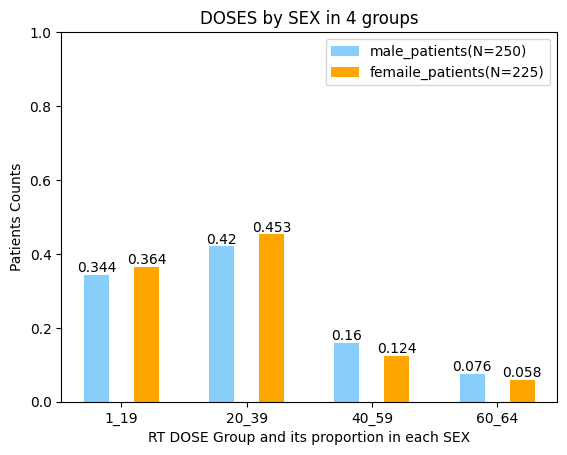

In [175]:
# DOSE Divided by sex
# use loc to label different groups
radio_m.loc[(0 < radio_m.RTACTUALDOSE) & (radio_m.RTACTUALDOSE < 20), 'RTgroup'] = '1_19'
radio_m.loc[(19 < radio_m.RTACTUALDOSE) & (radio_m.RTACTUALDOSE < 40), 'RTgroup'] = '20_39'
radio_m.loc[(39 < radio_m.RTACTUALDOSE) & (radio_m.RTACTUALDOSE < 60), 'RTgroup'] = '40_59'
radio_m.loc[(59 < radio_m.RTACTUALDOSE) & (radio_m.RTACTUALDOSE < 65), 'RTgroup'] = '60_64'

radio_f.loc[(0 < radio_f.RTACTUALDOSE) & (radio_f.RTACTUALDOSE < 20), 'RTgroup'] = '1_19'
radio_f.loc[(19 < radio_f.RTACTUALDOSE) & (radio_f.RTACTUALDOSE < 40), 'RTgroup'] = '20_39'
radio_f.loc[(39 < radio_f.RTACTUALDOSE) & (radio_f.RTACTUALDOSE < 60), 'RTgroup'] = '40_59'
radio_f.loc[(59 < radio_f.RTACTUALDOSE) & (radio_f.RTACTUALDOSE < 65), 'RTgroup'] = '60_64'

# drop_duplicates in case any repeat
radio_m.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
radio_f.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# use one charc to carry the bar plot
m = plt.bar(np.arange(len(radio_m.groupby('RTgroup')['SEX'].count()))-0.2, [round(i,3) for i in (radio_m.groupby('RTgroup')['SEX'].count())/250], width=0.2, color='lightskyblue', label = 'male_patients(N=250)')
f = plt.bar(np.arange(len(radio_f.groupby('RTgroup')['SEX'].count()))+0.2, [round(i,3) for i in (radio_f.groupby('RTgroup')['SEX'].count())/225], width=0.2, color='orange', label = 'femaile_patients(N=225)')

# Show statistics
plt.xticks([0, 1, 2, 3],labels=['1_19', '20_39', '40_59', '60_64'])
plt.ylim(0, 1)
plt.xlabel('RT DOSE Group and its proportion in each SEX')
plt.ylabel('Patients Counts')
plt.title('DOSES by SEX in 4 groups')
plt.bar_label(m)
plt.bar_label(f)
plt.legend()
### Standard Dose should be 45-64, most patients seems not reached

## check if diff is significant

In [198]:
print(kstest(radio_m['RTACTUALDOSE'], 'norm'))
kstest(radio_f['RTACTUALDOSE'], 'norm')

KstestResult(statistic=0.9678408914098424, pvalue=0.0)


KstestResult(statistic=0.9909256837141779, pvalue=0.0)

In [199]:
import scipy.stats as stats
stat_val, p_val = stats.ttest_ind(radio_m['RTACTUALDOSE'], radio_f['RTACTUALDOSE'], equal_var=False)
print('2 sample t test p value,', p_val)


2 sample t test p value, 0.34300503931160753


## DOSEby grades

/tmp/ipykernel_3587902/3536779182.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3536779182.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3536779182.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3536779182.py:16: SettingWithCopyWarning:



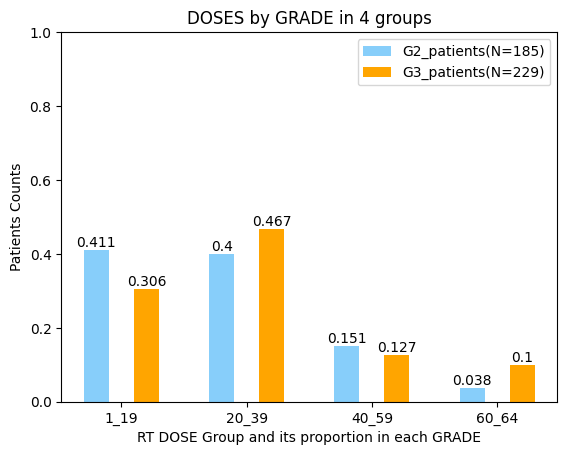

In [182]:
radio_G2=r_oligo[r_oligo.GRADE=='G2']
radio_G3=r_oligo[r_oligo.GRADE=='G3']

radio_G2.loc[(0 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 20), 'RTgroup'] = '1_19'
radio_G2.loc[(19 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 40), 'RTgroup'] = '20_39'
radio_G2.loc[(39 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 60), 'RTgroup'] = '40_59'
radio_G2.loc[(59 < radio_G2.RTACTUALDOSE) & (radio_G2.RTACTUALDOSE < 65), 'RTgroup'] = '60_64'

radio_G3.loc[(0 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 20), 'RTgroup'] = '1_19'
radio_G3.loc[(19 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 40), 'RTgroup'] = '20_39'
radio_G3.loc[(39 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 60), 'RTgroup'] = '40_59'
radio_G3.loc[(59 < radio_G3.RTACTUALDOSE) & (radio_G3.RTACTUALDOSE < 65), 'RTgroup'] = '60_64'

# drop_duplicates in case any repeat
radio_G2.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
radio_G3.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)


# use one charc to carry the bar plot
G2 = plt.bar(np.arange(len(radio_G2.groupby('RTgroup')['SEX'].count()))-0.2, [round(i,3) for i in (radio_G2.groupby('RTgroup')['SEX'].count())/185], width=0.2,color='lightskyblue', label = 'G2_patients(N=185)')
G3 = plt.bar(np.arange(len(radio_G3.groupby('RTgroup')['SEX'].count()))+0.2, [round(i,3) for i in (radio_G3.groupby('RTgroup')['SEX'].count())/229],width=0.2, color='orange', label = 'G3_patients(N=229)')

# Show statistics
plt.xticks([0, 1, 2, 3],labels=['1_19', '20_39', '40_59', '60_64'])
plt.ylim(0, 1)
plt.xlabel('RT DOSE Group and its proportion in each GRADE')
plt.ylabel('Patients Counts')
plt.title('DOSES by GRADE in 4 groups')
plt.bar_label(G2)
plt.bar_label(G3)
plt.legend()


In [192]:
from scipy.stats import kstest
kstest(radio_G2['RTACTUALDOSE'],'norm')

KstestResult(statistic=0.9728076339922529, pvalue=4.7176365183617e-290)

In [190]:
# stat_val, p_val = stats.ttest_ind(radio_G2['RTACTUALDOSE'], radio_G3['RTACTUALDOSE'], equal_var=False)
# print('2 sample t test p value,', p_val)

In [188]:
stat_val, p_val = stats.mannwhitneyu(radio_G2['RTACTUALDOSE'], radio_G3['RTACTUALDOSE'])
print('2 sample Mann Whitney test p value,', p_val)

2 sample Mann Whitney test p value, 0.05808501987326427


## How many patients follow original RT plan

In [464]:
## Check how many patients had undergone dose increase/decrease

radio_m.loc[radio_m.RTPRESCRIBEDDOSE < radio_m.RTACTUALDOSE, 'DOSE_compa']='More'
radio_m.loc[radio_m.RTPRESCRIBEDDOSE == radio_m.RTACTUALDOSE, 'DOSE_compa']='Equal'
radio_m.loc[radio_m.RTPRESCRIBEDDOSE > radio_m.RTACTUALDOSE, 'DOSE_compa']='Less'

radio_f.loc[radio_f.RTPRESCRIBEDDOSE < radio_f.RTACTUALDOSE, 'DOSE_compa']='More'
radio_f.loc[radio_f.RTPRESCRIBEDDOSE == radio_f.RTACTUALDOSE, 'DOSE_compa']='Equal'
radio_f.loc[radio_f.RTPRESCRIBEDDOSE > radio_f.RTACTUALDOSE, 'DOSE_compa']='Less'

/tmp/ipykernel_778728/1544636310.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/1544636310.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [465]:
radio_m.groupby('DOSE_compa')['PSEUDO_PATIENTID'].nunique()

DOSE_compa
Equal     29
Less     216
More       5
Name: PSEUDO_PATIENTID, dtype: int64

In [466]:
radio_f.groupby('DOSE_compa')['PSEUDO_PATIENTID'].nunique()

DOSE_compa
Equal     24
Less     197
More       4
Name: PSEUDO_PATIENTID, dtype: int64

(0.0, 200.0)

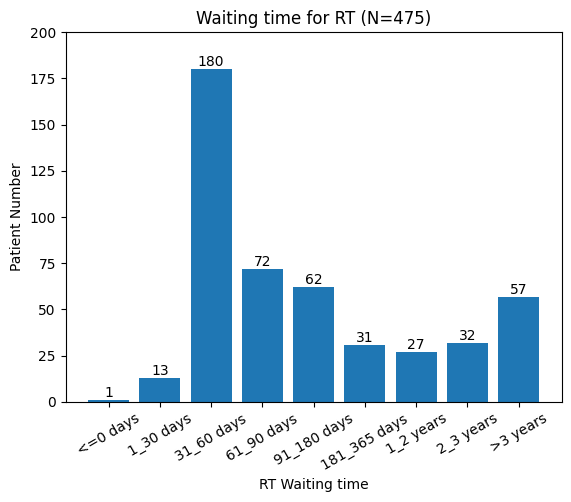

In [280]:
bin = [-100000, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
r_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
r_oligo['INTERVAL_DIAG_TO_TREAT_START'].replace(r'', np.nan, inplace = True)
r_oligo.dropna(axis=0, subset=['INTERVAL_DIAG_TO_TREAT_START'], inplace=True)

r_oligo['RTafterD'] = pd.cut(r_oligo['INTERVAL_DIAG_TO_TREAT_START'].astype(float).astype(int), bins = bin, labels=('SACT before Diag','0_29days', '30_59days', '60_89days', '90_179days', '180_364days', '1_2years', '2_3years', '>3years'))
r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique())), r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=30,labels=['<=0 days','1_30 days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('RT Waiting time')
plt.ylabel('Patient Number')
plt.title('Waiting time for RT (N=475)')
plt.ylim(0,200)


# SACT

In [82]:
# fetch the first 3 characters to get patients diagnosis code starting with C70/C71/C72
c_oligo = pd.read_sql("SELECT * FROM SACT WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX', '')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
c_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
c_oligo['PRIMARY_DIAGNOSIS']=c_oligo['PRIMARY_DIAGNOSIS'].astype(str)
c_oligo['site_ICD10']=c_oligo['PRIMARY_DIAGNOSIS'].astype(str).str[:3]

print('Patients number in SACT before cleaning:', c_oligo['PSEUDO_PATIENTID'].nunique())

# Choose the columns that we may need
chemo_icd=c_oligo[['PSEUDO_PATIENTID','site_ICD10','INTENT_OF_TREATMENT','MORPHOLOGY_CLEAN', 'BENCHMARK_GROUP','CYCLE_NUMBER','INTERVAL_DIAG_START_REGIMEN', 'DRUG_GROUP']]
chemo_icd.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

# Selecting patients that have a brain tumour diagnosis code in SACT 
diagnosis=('C71', 'C72')
chemo_bt=chemo_icd[chemo_icd.site_ICD10.isin(diagnosis)]
print(chemo_bt['site_ICD10'].value_counts())
print('Number of patients with a brain tumour diagnosis in SACT:', chemo_bt['PSEUDO_PATIENTID'].nunique())

Patients number in SACT before cleaning: 749
C71    697
C72      3
Name: site_ICD10, dtype: int64
Number of patients with a brain tumour diagnosis in SACT: 700


/tmp/ipykernel_3587902/2990457426.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
## reassign chemo_bt to chemo_oligo
chemo_oligo=pd.merge(chemo_bt, df,on='PSEUDO_PATIENTID')
chemo_oligo['PSEUDO_PATIENTID'].nunique()

691

## Check waiting time for SACT

(0.0, 350.0)

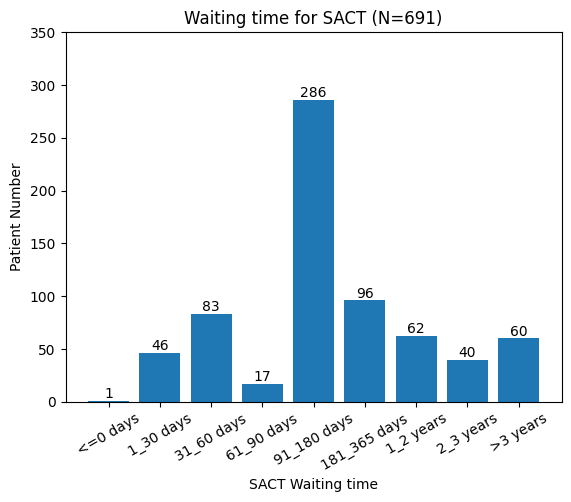

In [458]:
bin = [-100000, 0, 30, 60, 90, 180, 365, 730, 1095, 100000]
chemo_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
chemo_oligo['INTERVAL_DIAG_START_REGIMEN'].replace(r'', np.nan, inplace = True)
chemo_oligo.dropna(axis=0, subset=['INTERVAL_DIAG_START_REGIMEN'], inplace=True)

chemo_oligo['TafterD'] = pd.cut(chemo_oligo['INTERVAL_DIAG_START_REGIMEN'].astype(float).astype(int), bins = bin, labels=('SACT before Diag','0_29days', '30_59days', '60_89days', '90_179days', '180_364days', '1_2years', '2_3years', '>3years'))
chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique()

BAR=plt.bar(np.arange(len(chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique())), chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique())
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=30,labels=['<=0 days','1_30 days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
plt.bar_label(BAR)
plt.xlabel('SACT Waiting time')
plt.ylabel('Patient Number')
plt.title('Waiting time for SACT (N=691)')
plt.ylim(0, 350)


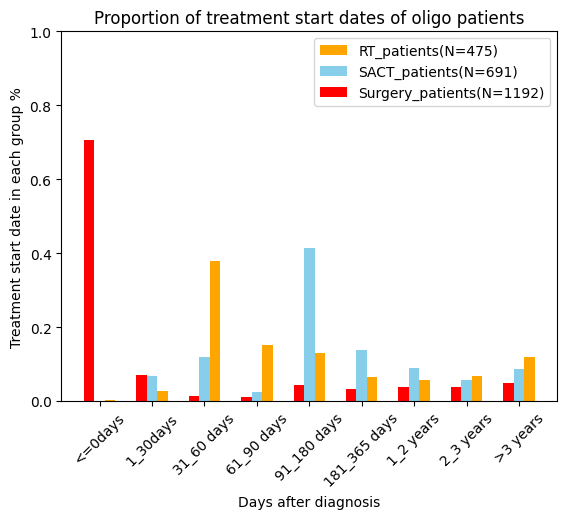

In [470]:
rt = plt.bar(np.arange(len(r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique()))+0.2, [round(i,3) for i in (r_oligo.groupby('RTafterD')['PSEUDO_PATIENTID'].nunique())/475], width=0.2, color='orange', label = 'RT_patients(N=475)')
sact = plt.bar(np.arange(len(chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique())), [round(i,3) for i in (chemo_oligo.groupby('TafterD')['PSEUDO_PATIENTID'].nunique())/691], width=0.2, color='skyblue', label = 'SACT_patients(N=691)')
surgery = plt.bar(np.arange(len(surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique()))-0.2, [round(i,3) for i in (surgery_or_bio.groupby('SafterD')['PSEUDO_PATIENTID'].nunique())/1192], width=0.2, color='red', label = 'Surgery_patients(N=1192)')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],rotation=45,labels=['<=0days','1_30days', '31_60 days', '61_90 days', '91_180 days', '181_365 days', '1_2 years', '2_3 years', '>3 years'])
# plt.bar_label(rt)
# plt.bar_label(sact)
# plt.bar_label(surgery)
plt.ylabel('Treatment start date in each group %')
plt.xlabel('Days after diagnosis')
plt.title('Proportion of treatment start dates of oligo patients')
plt.ylim(0,1)
plt.legend()


In [164]:
# braintumoursact['MORPHOLOGY_CLEAN']=braintumoursact['MORPHOLOGY_CLEAN'].astype(str)
# braintumoursact['MORPHO']=braintumoursact['MORPHOLOGY_CLEAN'].astype(str).str[:3]
# C_MORPHO=('945')
# morphosact=braintumoursact.query('MORPHO in @C_MORPHO')
# print('Number of oligo patients with a brain tumour diagnosis and correct morphology in SACT:', morphosact['PSEUDO_PATIENTID'].nunique())

## PCV + RT vs RT only, after patients underwent surgery

In [464]:
# Meihua Wang's paper(2009) has mentioned that PCV+RT could increase median sirvival time
# let's check if PCV+RT group's survival curve is really better than RT only

# use ~.isin() to clear patients who might underwent other chemo_therapy
RT_only_stillhave_surgery = r_oligo[~r_oligo['PSEUDO_PATIENTID'].isin(chemo_oligo['PSEUDO_PATIENTID'])]

# ~isin surgery_or_biopsy is not recommended since surgery is the basis of all kinds of treatments
RT_only = RT_only_stillhave_surgery[RT_only_stillhave_surgery['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who only had RT after surgery:',RT_only['PSEUDO_PATIENTID'].nunique())



Number of patients who only had RT after surgery: 96


In [462]:
## pcv have 2 drug groups, PCV and 'procarbazine + lomustine + vincristine

pcv = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
PCV_RT = pd.merge(pcv, r_oligo, on = 'PSEUDO_PATIENTID')

# don't forget to choose those in C70/C71/C72 diagnosis
# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
PCV_RT=Fetch_first(PCV_RT)
PCV_RT=PCV_RT[PCV_RT.site_ICD10.isin(diagnosis)]

# and choose those also underwent surgery in new version of codes
PCV_RT = PCV_RT[PCV_RT['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who have only undergone pcv + RT treatment after surgery:',PCV_RT['PSEUDO_PATIENTID'].nunique())


Number of patients who have only undergone pcv + RT treatment after surgery: 275


In [167]:
# RT_only_exclude_Chemo['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
# RT_only_exclude_Chemo.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
# RT_only_exclude_Chemo['VITALSTATUS_NEW'] = RT_only_exclude_Chemo.apply(conditions, axis = 1)
# kmf = KaplanMeierFitter()
# kmf.fit(durations = RT_only_exclude_Chemo['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = RT_only_exclude_Chemo['VITALSTATUS_NEW'], label = 'RT only')
# kmf.plot()
# print('Median survival RT_only: ', kmf.median_survival_time_)

# PCV_RT_mighthave_S['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
# PCV_RT_mighthave_S.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
# PCV_RT_mighthave_S['VITALSTATUS_NEW'] = PCV_RT_mighthave_S.apply(conditions, axis = 1)
# kmf = KaplanMeierFitter()
# kmf.fit(durations = PCV_RT_mighthave_S['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PCV_RT_mighthave_S['VITALSTATUS_NEW'], label = 'PCV + RT')
# kmf.plot()
# print('Median survival PCV_RT: ', kmf.median_survival_time_)

# plt.xlabel('Time(days)')
# plt.ylabel('Survival probability')
# plt.title('Survival of oligo patients: PCV+RT vs RT only')

# To note, these groups might contain surgeries as basis of treatments

# It is strange at the late stage of curves, maybe resections were already enough for recovery, and RT is a good adjuctive choice


Median survival RT_only:  inf
Median survival PCV_RT:  inf


/tmp/ipykernel_3587902/3268133030.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3268133030.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3268133030.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Survival of oligo patients: PCV+RT vs RT only')

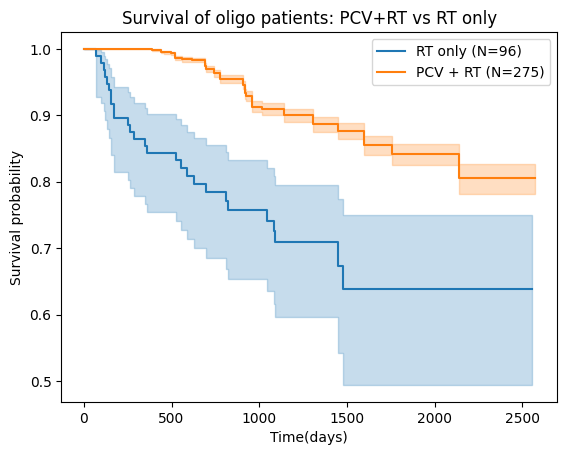

In [466]:
kmf=KaplanMeierFitter()
# never forget to drop NA before kmf
RT_only['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
RT_only.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
RT_only['VITALSTATUS_NEW'] = RT_only.apply(conditions, axis = 1)

# give a name to the fitter for later log_rank test
rt=kmf.fit(durations = RT_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = RT_only['VITALSTATUS_NEW'], label = 'RT only (N=96)')
kmf.plot()
print('Median survival RT_only: ', kmf.median_survival_time_)

PCV_RT['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
PCV_RT.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
PCV_RT['VITALSTATUS_NEW'] = PCV_RT.apply(conditions, axis = 1)

# give a name to the fitter for later log_rank test
pcv_rt=kmf.fit(durations = PCV_RT['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PCV_RT['VITALSTATUS_NEW'], label = 'PCV + RT (N=275)')
kmf.plot()
print('Median survival PCV_RT: ', kmf.median_survival_time_)

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of oligo patients: PCV+RT vs RT only')

# this comparison is way more clear 

In [468]:
PR_results = logrank_test(PCV_RT['INTERVAL_DIAG_TO_VS'], RT_only['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = PCV_RT.apply(conditions,axis=1).astype(int),
                       event_observed_B = RT_only.apply(conditions,axis=1).astype(int))
PR_results.print_summary()
# Great, now this comparison can be defined as valid

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          46.77 <0.005     36.87

## To compare TMZ only vs TMZ+RT, the conservative way is to query only in benchmark_group, however it would make the patient number in TMZ+RT group looks too small

In [472]:
## left merge, same for TMZ+RT
tmz = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('TEMOZOLOMIDE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
TMZ = pd.merge(tmz, df, on = 'PSEUDO_PATIENTID')
print('before site_icd10 cleaning, patient number of TMZ only Group:', TMZ['PSEUDO_PATIENTID'].nunique())

# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
TMZ['PRIMARY_DIAGNOSIS']=TMZ['PRIMARY_DIAGNOSIS'].astype(str)
TMZ['site_ICD10']=TMZ['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
TMZ_clean=TMZ[TMZ.site_ICD10.isin(diagnosis)]
print('after cleaning patients who dont have C70/C71/C72 codes:', TMZ_clean['PSEUDO_PATIENTID'].nunique())

TMZ_clean_exradio = TMZ_clean[~TMZ_clean['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]
print('after excluding patients in RTDS, patient number:',TMZ_clean_exradio['PSEUDO_PATIENTID'].nunique())

# and choose those also underwent surgery in new version of codes
TMZ_final = TMZ_clean_exradio[TMZ_clean_exradio['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who have only undergone TMZ treatment after surgery:',TMZ_final['PSEUDO_PATIENTID'].nunique())


before site_icd10 cleaning, patient number of TMZ only Group: 326
after cleaning patients who dont have C70/C71/C72 codes: 307
after excluding patients in RTDS, patient number: 160
Number of patients who have only undergone TMZ treatment after surgery: 154


In [473]:
## add a group to TMZ_inradio since only quering TMZ+RT in Benchamark group, N is too small

TMZ_clean_inradio = TMZ_clean[TMZ_clean['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]
TMZ_clean_inradio['PSEUDO_PATIENTID'].nunique()


147

In [474]:
## TMZ+RT
tmz_rt = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('TEMOZOLOMIDE + RT') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
TMZ_RT = pd.merge(tmz_rt, df, on = 'PSEUDO_PATIENTID', how='left')
print('before site_icd10 cleaning, patient number of TMZ+RT benchmark Group:', TMZ_RT['PSEUDO_PATIENTID'].nunique())

# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
TMZ_RT['PRIMARY_DIAGNOSIS']=TMZ_RT['PRIMARY_DIAGNOSIS'].astype(str)
TMZ_RT['site_ICD10']=TMZ_RT['PRIMARY_DIAGNOSIS'].astype(str).str[:3]
TMZ_RTclean=TMZ_RT[TMZ_RT.site_ICD10.isin(diagnosis)]
print('after cleaning patients who dont have C70/C71/C72 codes, TMZ+RT benchmark Group:', TMZ_RTclean['PSEUDO_PATIENTID'].nunique())

# make sure no matter TMZ+RT benchmark group or TMZalsoinRTDS group all in RTDS table
TMZplusRT_clean = TMZ_RTclean[TMZ_RTclean['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]
TMZ_concat=pd.concat([TMZplusRT_clean, TMZ_clean_inradio])
print('after locking patients in RTDS and concat TMZinRTDS group, patient number:',TMZ_concat['PSEUDO_PATIENTID'].nunique())

# and choose those also underwent surgery in new version of codes
TMZ_RTfinal = TMZ_concat[TMZ_concat['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

print('Number of patients who have undergone TMZ and RTtreatment after surgery:',TMZ_RTfinal['PSEUDO_PATIENTID'].nunique())


before site_icd10 cleaning, patient number of TMZ+RT benchmark Group: 85
after cleaning patients who dont have C70/C71/C72 codes, TMZ+RT benchmark Group: 77
after locking patients in RTDS and concat TMZinRTDS group, patient number: 149
Number of patients who have undergone TMZ and RTtreatment after surgery: 145


/tmp/ipykernel_3587902/413356648.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/413356648.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/413356648.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/413356648.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Text(0.5, 1.0, 'Survival of oligo patients: TMZ+RT vs TMZ only')

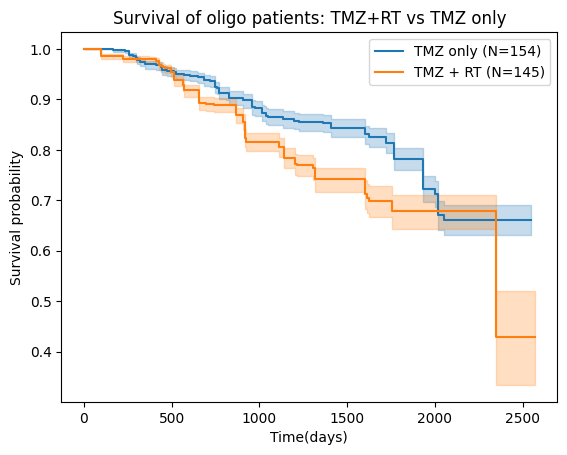

In [475]:
# never forget to drop NA before kmf
TMZ_final['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
TMZ_final.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
TMZ_final['VITALSTATUS_NEW'] = TMZ_final.apply(conditions, axis = 1)
kmf=KaplanMeierFitter()
tmz=kmf.fit(durations = TMZ_final['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_final['VITALSTATUS_NEW'], label = 'TMZ only (N=154)')
kmf.plot()

TMZ_RTfinal['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
TMZ_RTfinal.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
TMZ_RTfinal['VITALSTATUS_NEW'] = TMZ_RTfinal.apply(conditions, axis = 1)
tmz_rt=kmf.fit(durations = TMZ_RTfinal['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_RTfinal['VITALSTATUS_NEW'], label = 'TMZ + RT (N=145)')
kmf.plot()

plt.xlabel('Time(days)')
plt.ylabel('Survival probability')
plt.title('Survival of oligo patients: TMZ+RT vs TMZ only')


## Significant difference found, but we could also check their sequences later, since we don't know which contribute more to this result, TMZ+RT or RT+TMZ? 

In [476]:
TR_results = logrank_test(TMZ_final['INTERVAL_DIAG_TO_VS'], TMZ_RTfinal['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = TMZ_final.apply(conditions,axis=1).astype(int),
                       event_observed_B = TMZ_RTfinal.apply(conditions,axis=1).astype(int))
TR_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          34.01 <0.005     27.44

## Build groups for seqs

In [477]:
## prim is almost same with r_oligo, just did not merge with df
rtds_oligo=prim

# and only select the useful column
rtds_oligo=rtds_oligo[['PSEUDO_PATIENTID', 'INTERVAL_DIAG_TO_TREAT_START']]
TMZ_RTfinal=TMZ_RTfinal[['PSEUDO_PATIENTID', 'INTERVAL_DIAG_START_REGIMEN']]

# drop NA and duplicates
TMZ_RTfinal.dropna(subset='INTERVAL_DIAG_START_REGIMEN', axis=0)
TMZ_RTfinal.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
rtds_oligo.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)

/tmp/ipykernel_3587902/1198997592.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [478]:
# Merge TMZ_RTfinal with oligo patients in RTDS, and df in order to applay kmf
TMZ_RT_withT=pd.merge(TMZ_RTfinal, rtds_oligo)
TMZ_RT_withI=pd.merge(TMZ_RT_withT, df, how='left')
TMZ_RT_withI.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
print('after merging with patients in RTDS and TUM_PAT, patient number:' ,TMZ_RT_withI['PSEUDO_PATIENTID'].nunique())


after merging with patients in RTDS and TUM_PAT, patient number: 145


In [488]:
TMZ_RT_withI.loc[(TMZ_RT_withI.INTERVAL_DIAG_TO_TREAT_START > TMZ_RT_withI.INTERVAL_DIAG_START_REGIMEN), 'seq'] = 'TMZ_then_RT'
TMZ_RT_withI.loc[(TMZ_RT_withI.INTERVAL_DIAG_TO_TREAT_START < TMZ_RT_withI.INTERVAL_DIAG_START_REGIMEN), 'seq'] = 'RT_then_TMZ'
TMZ_RT_withI.loc[(TMZ_RT_withI.INTERVAL_DIAG_TO_TREAT_START == TMZ_RT_withI.INTERVAL_DIAG_START_REGIMEN), 'seq'] = 'RT_TMZsame'
# os.chdir('/home/ll6222/Documents/DS175/share/19_Rare tumours')
# TMZ_RT_withT.to_csv('TMZ RT seq survival comparison.csv')

# these codes looks very repeated but practical
tmz_then_rt='TMZ_then_RT'
tmz_then_rt=TMZ_RT_withI.query('seq in @tmz_then_rt')
print('tmz,then rt',tmz_then_rt['PSEUDO_PATIENTID'].nunique())

rt_then_tmz='RT_then_TMZ'
rt_then_tmz=TMZ_RT_withI.query('seq in @rt_then_tmz')
print('rt,then tmz',rt_then_tmz['PSEUDO_PATIENTID'].nunique())

tmz_rt_s='RT_TMZsame'
tmz_rt_s=TMZ_RT_withI.query('seq in @tmz_rt_s')
print('tmz and rt smae time',tmz_rt_s['PSEUDO_PATIENTID'].nunique())


tmz,then rt 60
rt,then tmz 79
tmz and rt smae time 6


/tmp/ipykernel_778728/597192751.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/597192751.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/597192751.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_778728/597192751.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.

Text(0, 0.5, 'Survival Probability')

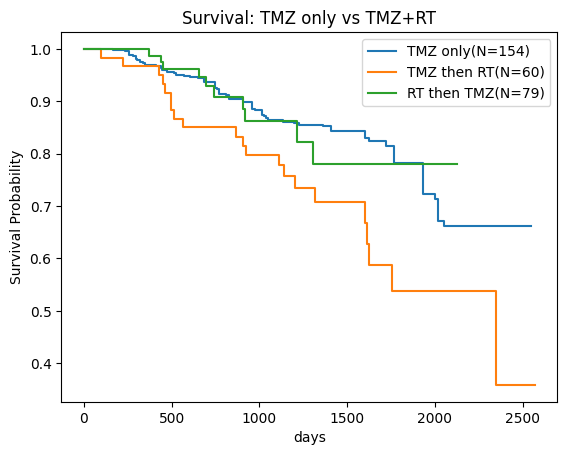

In [489]:

TMZ_final['INTERVAL_DIAG_TO_VS'].replace(r'', np.nan, inplace = True)
TMZ_final.dropna(axis = 0, subset=['INTERVAL_DIAG_TO_VS', 'VITALSTATUS'], inplace = True)
TMZ_final['VITALSTATUS_NEW'] = TMZ_final.apply(conditions, axis = 1)
tmz=kmf.fit(durations = TMZ_final['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_final['VITALSTATUS_NEW'], label = 'TMZ only(N=154)')
kmf.plot(ci_show=False)

tmz_then_rt['VITALSTATUS_NEW'] = tmz_then_rt.apply(conditions, axis = 1)
TMZ_RT=kmf.fit(durations = tmz_then_rt['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = tmz_then_rt['VITALSTATUS_NEW'], label = 'TMZ then RT(N=60)')
kmf.plot(ci_show=False)

rt_then_tmz['VITALSTATUS_NEW'] = rt_then_tmz.apply(conditions, axis = 1)
rt_tmz=kmf.fit(durations = rt_then_tmz['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = rt_then_tmz['VITALSTATUS_NEW'], label = 'RT then TMZ(N=79)')
kmf.plot(ci_show=False)

# tmz_rt_s['VITALSTATUS_NEW'] = tmz_rt_s.apply(conditions, axis = 1)
# tmz_rt_same=kmf.fit(durations = tmz_rt_s['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = tmz_rt_s['VITALSTATUS_NEW'], label = 'TMZ_RT same time(N=6)')
# kmf.plot(ci_show=False)

plt.title('Survival: TMZ only vs TMZ+RT')
plt.xlabel('days')
plt.ylabel('Survival Probability')

In [490]:
Tonly_RTthenTMZ_results = logrank_test(TMZ_final['INTERVAL_DIAG_TO_VS'], rt_then_tmz['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = TMZ_final.apply(conditions,axis=1).astype(int),
                       event_observed_B = rt_then_tmz.apply(conditions,axis=1).astype(int))
Tonly_RTthenTMZ_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.17 0.68      0.56

In [491]:
Tonly_TMZthenRT_results = logrank_test(TMZ_final['INTERVAL_DIAG_TO_VS'], tmz_then_rt['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = TMZ_final.apply(conditions,axis=1).astype(int),
                       event_observed_B = tmz_then_rt.apply(conditions,axis=1).astype(int))
Tonly_TMZthenRT_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.97 <0.005     10.08

## Discovery into PCV comparing with TMZ (plus RT or not)

In [470]:
## build a group for PCV only
pcv = pd.read_sql("SELECT * FROM SACT WHERE BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)

## not in RTDS
pcv_only = pcv[~pcv['PSEUDO_PATIENTID'].isin(r_oligo['PSEUDO_PATIENTID'])]

# don't forget to choose those in C70/C71/C72 diagnosis
# diagnosis=('C70', 'C71', 'C72'), fetch the first 3 characters in Primary diagnosis column of new dataframe to double check
pcv_only=Fetch_first(pcv_only)

pcv_only=pcv_only[pcv_only.site_ICD10.isin(diagnosis)]

# and choose those also underwent surgery in new version of codes
pcv_only = pcv_only[pcv_only['PSEUDO_PATIENTID'].isin(surgery_or_bio['PSEUDO_PATIENTID'])]

# and merge it with TUM_PAT for KaplanMeier 's applicaiton
pcv_only=pd.merge(df,pcv_only, on='PSEUDO_PATIENTID')
print('pcv only patients count',pcv_only['PSEUDO_PATIENTID'].nunique())

pcv only patients count 194


/tmp/ipykernel_3587902/684434533.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/684434533.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_3587902/684434533.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/684434533.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/2080809141.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 1.0302169052325554)

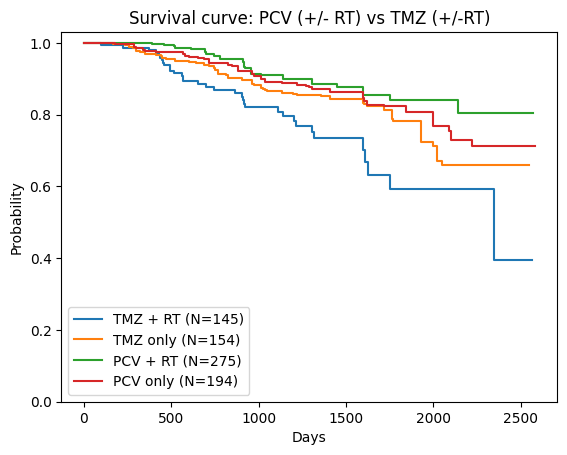

In [480]:
## PCV RT vs TMZ RT vs TMZ only vs PCV only
TMZ_RT_withI=Drop(TMZ_RT_withI)
TMZ_RT_withI['VITALSTATUS_NEW'] = TMZ_RT_withI.apply(conditions, axis = 1)
tmz_rt=kmf.fit(durations = TMZ_RT_withI['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_RT_withI['VITALSTATUS_NEW'], label = 'TMZ + RT (N=145)')
kmf.plot(ci_show=False)

TMZ_final=Drop(TMZ_final)
TMZ_final['VITALSTATUS_NEW'] = TMZ_final.apply(conditions, axis = 1)
tmz=kmf.fit(durations = TMZ_final['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = TMZ_final['VITALSTATUS_NEW'], label = 'TMZ only (N=154)')
kmf.plot(ci_show=False)

PCV_RT=Drop(PCV_RT)
PCV_RT['VITALSTATUS_NEW'] = PCV_RT.apply(conditions, axis = 1)
pcv_rt=kmf.fit(durations = PCV_RT['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = PCV_RT['VITALSTATUS_NEW'], label = 'PCV + RT (N=275)')
kmf.plot(ci_show=False)

pcv_only=Drop(pcv_only)
pcv_only['VITALSTATUS_NEW'] = pcv_only.apply(conditions, axis = 1)
pcv=kmf.fit(durations = pcv_only['INTERVAL_DIAG_TO_VS'].astype(int), event_observed = pcv_only['VITALSTATUS_NEW'], label = 'PCV only (N=194)')
kmf.plot(ci_show=False)

plt.xlabel('Days')
plt.title('Survival curve: PCV (+/- RT) vs TMZ (+/-RT)')
plt.ylabel('Probability')
plt.ylim(0,)

In [481]:
PCVRT_PCVonly_results = logrank_test(PCV_RT['INTERVAL_DIAG_TO_VS'], pcv_only['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = PCV_RT.apply(conditions,axis=1).astype(int),
                       event_observed_B = pcv_only.apply(conditions,axis=1).astype(int))
PCVRT_PCVonly_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          18.95 <0.005     16.19

In [482]:
PCVRT_TMZonly_results = logrank_test(PCV_RT['INTERVAL_DIAG_TO_VS'], TMZ_final['INTERVAL_DIAG_TO_VS'],
                       event_observed_A = PCV_RT.apply(conditions,axis=1).astype(int),
                       event_observed_B = TMZ_final.apply(conditions,axis=1).astype(int))
PCVRT_TMZonly_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          62.72 <0.005     48.57

## Check the drug group and dose differences between G2/G3

In [508]:
## merge with df first, still N=691

G2_chemo=chemo_oligo[chemo_oligo.GRADE=='G2']
G3_chemo=chemo_oligo[chemo_oligo.GRADE=='G3']
G2_chemo.drop_duplicates(subset='PSEUDO_PATIENTID')
G3_chemo.drop_duplicates(subset='PSEUDO_PATIENTID')
print('Number of G2 patients in SACT', G2_chemo['PSEUDO_PATIENTID'].nunique())
print('Number of G3 patients in SACT', G3_chemo['PSEUDO_PATIENTID'].nunique())


Number of G2 patients in SACT 226
Number of G3 patients in SACT 376


In [509]:
G2_chemo.groupby(['BENCHMARK_GROUP', 'INTENT_OF_TREATMENT'])['PSEUDO_PATIENTID'].nunique()

BENCHMARK_GROUP                         INTENT_OF_TREATMENT
CNS HIGH GRADE GLIOMA PCV               A                       1
LOMUSTINE                               A                       1
                                        P                       1
LOMUSTINE + PROCARBAZINE + VINCRISTINE                          8
                                        A                      61
                                        C                       9
                                        N                       2
                                        P                      15
NOT CHEMO                               A                       2
                                        P                       2
PCV                                                             2
                                        A                      29
                                        C                       4
                                        D                       2
                

In [510]:
G3_chemo.groupby(['BENCHMARK_GROUP', 'INTENT_OF_TREATMENT'])['PSEUDO_PATIENTID'].nunique()

BENCHMARK_GROUP                         INTENT_OF_TREATMENT
BR14 TRIAL                              A                       1
CARBOPLATIN                             P                       1
CNS HIGH GRADE GLIOMA PCV               A                       1
LOMUSTINE                               A                       1
                                        P                       2
LOMUSTINE + PROCARBAZINE + VINCRISTINE                          6
                                        A                      74
                                        C                       8
                                        N                       1
                                        P                      12
NOT CHEMO                               A                       4
OLAPARIB                                P                       1
PCV                                                             8
                                        A                      95
                

In [511]:
chemo_oligo.loc[(17 < chemo_oligo.AGE) & (chemo_oligo.AGE < 45), 'Agroup'] = '18_44' # 
chemo_oligo.loc[(44 < chemo_oligo.AGE) & (chemo_oligo.AGE < 70), 'Agroup'] = '45_69' # 
chemo_oligo.loc[(69 < chemo_oligo.AGE) & (chemo_oligo.AGE < 100), 'Agroup'] = '70_99' # 

young=('18_44')
middle=('45_69')
old=('70_99')

chemo_18_44 = chemo_oligo.query('Agroup in @young') 
chemo_45_69 = chemo_oligo.query('Agroup in @middle')
chemo_70_99 = chemo_oligo.query('Agroup in @old')


In [515]:
chemo_18_44.groupby(['BENCHMARK_GROUP', 'INTENT_OF_TREATMENT'])['PSEUDO_PATIENTID'].nunique()

BENCHMARK_GROUP                         INTENT_OF_TREATMENT
BR14 TRIAL                              A                       1
CNS HGG                                 A                       1
CNS HIGH GRADE GLIOMA PCV               A                       1
HORMONES                                                        1
LOMUSTINE                               A                       1
                                        P                       1
LOMUSTINE + PROCARBAZINE + VINCRISTINE                         11
                                        A                      75
                                        C                       7
                                        N                       3
                                        P                      18
NOT CHEMO                                                       1
                                        A                       4
                                        P                       2
PCV             

In [516]:
chemo_45_69.groupby(['BENCHMARK_GROUP', 'INTENT_OF_TREATMENT'])['PSEUDO_PATIENTID'].nunique()

BENCHMARK_GROUP                         INTENT_OF_TREATMENT
CARBOPLATIN                             P                       1
CNS HIGH GRADE GLIOMA PCV               A                       2
CVP                                     P                       1
LOMUSTINE                               A                       1
                                        P                       2
LOMUSTINE + PROCARBAZINE + VINCRISTINE                          6
                                        A                      72
                                        C                      13
                                        P                      10
NOT CHEMO                               A                       3
PCV                                                             5
                                        A                      58
                                        C                       4
                                        D                       5
                

In [517]:
chemo_70_99.groupby(['BENCHMARK_GROUP', 'INTENT_OF_TREATMENT'])['PSEUDO_PATIENTID'].nunique()

BENCHMARK_GROUP                         INTENT_OF_TREATMENT
LOMUSTINE                               P                      1
LOMUSTINE + PROCARBAZINE + VINCRISTINE                         1
                                        A                      6
                                        P                      3
NOT CHEMO                               A                      1
OLAPARIB                                P                      1
PCV                                     P                      2
TEMOZOLOMIDE                            A                      1
                                        C                      2
                                        P                      6
TEMOZOLOMIDE + RT                                              1
                                        C                      1
                                        P                      2
Name: PSEUDO_PATIENTID, dtype: int64

## COX version 4

In [256]:
## firstly we need to deal with NA in GRADE
df['GRADE'].replace('','GX', inplace=True)
df['GRADE'].replace('GX','NOS', inplace=True)
df_cox=df[['PSEUDO_PATIENTID','AGE', 'SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE', 'VITALSTATUS', 'INTERVAL_DIAG_TO_VS', 'SITE_ICD10_O2']]

# Clean data as usual
df_cox['VITALSTATUS'].replace(r'A', 0, inplace=True)
df_cox['VITALSTATUS'].replace(r'D', 1, inplace=True)

## black, asian, white and NOS
df_cox['ETHNICITYNAME'].replace('ANY OTHER BLACK BACKGROUND', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK AFRICAN', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK CARIBBEAN', 'BLACK', inplace=True)

df_cox['ETHNICITYNAME'].replace('CHINESE', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN INDIAN', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN PAKISTANI', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ASIAN BACKGROUND', 'ASIAN', inplace=True)

df_cox['ETHNICITYNAME'].replace('WHITE IRISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('WHITE BRITISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER WHITE BACKGROUND', 'WHITE', inplace=True)

df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT KNOWN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT STATED', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ETHNIC GROUP', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND ASIAN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND BLACK CARIBBEAN', 'Ethnicity NOS', inplace=True)

## C71 and C72
df_cox['SITE_ICD10_O2'].replace('C725', 'C72', inplace=True)

df_cox['SITE_ICD10_O2'].replace('C710', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C711', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C712', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C713', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C714', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C716', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C718', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C719', 'C71', inplace=True)

## Most/middle/Least deprived
df_cox['INCOME_QUINTILE_2015'].replace('1 - Least deprived', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('2', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('3', 'Middle deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('4', 'Most deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('5 - Most deprived', 'Most deprived', inplace=True)

/tmp/ipykernel_3587902/3772205754.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3772205754.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3772205754.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3772205754.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [257]:
# Build columns for RT, CHEMO-TMZ, CHEMO-PCV, Surgery, Biopsy

df_cox['RT']=0
# df_cox['RT <= 40Gy']=0

df_cox['PCV-Palliative']=0
df_cox['PCV-Curative']=0
# df_cox['PCV-Adjuvant']=0

df_cox['TMZ-Palliative']=0
df_cox['TMZ-Curative']=0
# df_cox['TMZ-Adjuvant']=0

df_cox['Resection']=0
df_cox['Biopsy']=0

/tmp/ipykernel_3587902/3080287119.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3080287119.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3080287119.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

## Rebuild PCV/TMZ dataframe 

In [366]:
pcv = pd.read_sql("SELECT * FROM SACT WHERE (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND BENCHMARK_GROUP IN ('PCV', 'LOMUSTINE + PROCARBAZINE + VINCRISTINE') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
pcv=pd.merge(pcv,df,on='PSEUDO_PATIENTID')

pcv.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
print('after SITE_ICD10 cleaning, PCV patient number',pcv['PSEUDO_PATIENTID'].nunique())

tmz = pd.read_sql("SELECT * FROM SACT WHERE (PRIMARY_DIAGNOSIS LIKE 'C71_' or 'C72_') AND BENCHMARK_GROUP IN ('TEMOZOLOMIDE', 'TEMOZOLOMIDE + RT') AND PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)));",conn)
tmz = pd.merge(tmz, df, on = 'PSEUDO_PATIENTID')

tmz.drop_duplicates(subset='PSEUDO_PATIENTID', inplace=True)
print('after SITE_ICD10 cleaning, TMZ patient number', tmz['PSEUDO_PATIENTID'].nunique())


after SITE_ICD10 cleaning, PCV patient number 458
after SITE_ICD10 cleaning, TMZ patient number 299


## Rebuild RTDS dataframe

In [260]:
radio_oligo = pd.read_sql("SELECT * FROM RTDS WHERE PSEUDO_PATIENTID IN (SELECT PSEUDO_PATIENTID FROM TUM_PAT WHERE MORPH_ICD10_O2 IN (9450, 9451) AND (GRADE IN ('G2', 'G3', 'GX','')) AND (INTERVAL_DIAG_TO_VS != '') AND (VITALSTATUS IN ('A', 'D')) AND (ETHNICITY IN ('A','B', 'C', 'D', 'F', 'G', 'H', 'J', 'L', 'M', 'N', 'P', 'R', 'S', 'X', 'Z')) AND (DIAGNOSISYEAR IN (2013,2014,2015,2016,2017,2018)) AND (SEX IN (1,2)) AND (BASISOFDIAGNOSIS IN (1,2,7,9)) );",conn)
radio_oligo.drop_duplicates(subset=['PSEUDO_PATIENTID'], inplace=True)
radio_oligo['PRIMARYDIAGNOSISICD']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str)
radio_oligo['ICD10']=radio_oligo['PRIMARYDIAGNOSISICD'].astype(str).str[:3]

# Creating a dataframe that locks from the original dataframe the patient id and the new ICD10 column
radio_P=radio_oligo[['PSEUDO_PATIENTID','ICD10','INTERVAL_DIAG_TO_TREAT_START' ,'RTTREATMENTREGION', 'RTPRESCRIBEDDOSE','ACTUALFRACTIONS', 'RTACTUALDOSE']]

diagnosis=('C71', 'C72')
rtds=radio_P[radio_P.ICD10.isin(diagnosis)]
print('Number of patients that had an ICD 10 code of C71 or C72:', rtds['PSEUDO_PATIENTID'].nunique())

print('Number of patients without a brain tumour diagnosis in RTDS:', radio_oligo['PSEUDO_PATIENTID'].nunique() - rtds['PSEUDO_PATIENTID'].nunique())

# Creating a list with the values of the variable (region of treatment) that we want to get numbers for
primary=('P', 'R', 'PR')
# Creating a dataframe that retains only the rows with the values we selected before in the list
prim=rtds[rtds.RTTREATMENTREGION.isin(primary)]
radio_oligo=pd.merge(prim,df,on='PSEUDO_PATIENTID')
radio_oligo['PSEUDO_PATIENTID'].nunique()

Number of patients that had an ICD 10 code of C71 or C72: 791
Number of patients without a brain tumour diagnosis in RTDS: 32


749

## Deeper classification of SACT

In [262]:
pcv_r=pcv[pcv.INTENT_OF_TREATMENT == 'C']
pcv_p=pcv[pcv.INTENT_OF_TREATMENT == 'P']
pcv_a=pcv[pcv.INTENT_OF_TREATMENT == 'A']
pcv_n=pcv[pcv.INTENT_OF_TREATMENT == 'N']

tmz_r=tmz[tmz.INTENT_OF_TREATMENT == 'C']
tmz_p=tmz[tmz.INTENT_OF_TREATMENT == 'P']
tmz_a=tmz[tmz.INTENT_OF_TREATMENT == 'A']
tmz_n=tmz[tmz.INTENT_OF_TREATMENT == 'N']

## Using loc() to label

In [263]:
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(radio_oligo['PSEUDO_PATIENTID']), 'RT'] = 1 # N=749

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_p['PSEUDO_PATIENTID']), 'PCV-Palliative'] = 1  # N=59
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_r['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=18
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_a['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=212
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_n['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=2, N(curative)=232

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_p['PSEUDO_PATIENTID']), 'TMZ-Palliative'] = 1  # N=106
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_r['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=52
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_a['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=93
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_n['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=7, N(curative)=152

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(df_surgery['PSEUDO_PATIENTID']), 'Resection'] = 1  # N=1015
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(df_biopsy['PSEUDO_PATIENTID']), 'Biopsy'] = 1  # N=644

In [264]:
# drop id ad get dummies
df_cox.drop(columns='PSEUDO_PATIENTID', inplace=True)
df_cox=pd.get_dummies(df_cox, columns=['SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE','RT' ,'SITE_ICD10_O2','TMZ-Palliative','TMZ-Curative','PCV-Palliative', 'PCV-Curative'])


/tmp/ipykernel_3587902/412798979.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [265]:
cph=CoxPHFitter(penalizer=0.1)
### default l1_ratio=0, means we dont need l2 regulation for feature selection
cph.fit(df_cox, "INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1271 total observations, 978 right-censored observations>
             duration col = 'INTERVAL_DIAG_TO_VS'
                event col = 'VITALSTATUS'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1271
number of events observed = 293
   partial log-likelihood = -1850.54
         time fit was run = 2023-01-10 21:43:01 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
AGE                                    0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
Resection                             -0.43       0.65       0.12            -0.66            -0.19                 0.52                 0.82
Biopsy                                 0.07       1.07       0.10            -0.13             0.27                 0.88                 1.31
SEX_1                                  0.01       1.02       0.14            -0.25             0.28                 0.78                 1.33
SEX_2                                 -0.01       0.99       0.14            -0.28             0.25                 0.75                 1.29
INCOME_QUINTILE_2015_Least deprived   -0.03       0.98       0.13            -0.28             0.23                 0.76                 1.26
INCOME_QUINTILE_2015_Middle deprived  -0.10       0.90       0.15            -0.39             0.19                 0.68                 1.21
INCOME_QUINTILE_2015_Most deprived     0.10       1.10       0.13            -0.16             0.35                 0.85                 1.42
ETHNICITYNAME_ASIAN                    0.01       1.01       0.25            -0.48             0.49                 0.62                 1.63
ETHNICITYNAME_BLACK                   -0.03       0.97       0.50            -1.00             0.95                 0.37                 2.59
ETHNICITYNAME_Ethnicity NOS           -0.10       0.90       0.27            -0.64             0.43                 0.53                 1.54
ETHNICITYNAME_WHITE                    0.04       1.04       0.20            -0.36             0.44                 0.70                 1.56
GRADE_G2                              -0.46       0.63       0.13            -0.72            -0.20                 0.49                 0.82
GRADE_G3                               0.31       1.36       0.13             0.05             0.57                 1.05                 1.77
GRADE_NOS                              0.28       1.33       0.15            -0.02             0.58                 0.98                 1.79
RT_0                                   0.03       1.03       0.14            -0.24             0.31                 0.79                 1.36
RT_1                                  -0.03       0.97       0.14            -0.31             0.24                 0.74                 1.27
SITE_ICD10_O2_C71                      1.07       2.90       2.57            -3.97             6.10                 0.02               446.54
SITE_ICD10_O2_C72                     -1.07       0.34       2.57            -6.10             3.97                 0.00                53.06
TMZ-Palliative_0                      -0.20       0.82       0.24            -0.67             0.27                 0.51                 1.31
TMZ-Palliative_1                       0.20       1.22       0.24            -0.27             0.67                 0.76                 1.96
TMZ-Curative_0                        -0.00       1.00       0.21            -0.41             0.41                 0.66                 1.51
TMZ-Curative_1                         0.00       1.00       0.21            -0.41             0.41                 0.66                 1.51
PCV-P

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, 'SITE_ICD10_O2_C72'),
  Text(0, 1, 'GRADE_G2'),
  Text(0, 2, 'Resection'),
  Text(0, 3, 'PCV-Curative_1'),
  Text(0, 4, 'TMZ-Palliative_0'),
  Text(0, 5, 'PCV-Palliative_0'),
  Text(0, 6, 'ETHNICITYNAME_Ethnicity NOS'),
  Text(0, 7, 'INCOME_QUINTILE_2015_Middle deprived'),
  Text(0, 8, 'RT_1'),
  Text(0, 9, 'ETHNICITYNAME_BLACK'),
  Text(0, 10, 'INCOME_QUINTILE_2015_Least deprived'),
  Text(0, 11, 'SEX_2'),
  Text(0, 12, 'TMZ-Curative_0'),
  Text(0, 13, 'TMZ-Curative_1'),
  Text(0, 14, 'ETHNICITYNAME_ASIAN'),
  Text(0, 15, 'SEX_1'),
  Text(0, 16, 'RT_0'),
  Text(0, 17, 'AGE'),
  Text(0, 18, 'ETHNICITYNAME_WHITE'),
  Text(0, 19, 'Biopsy'),
  Text(0, 20, 'INCOME_QUINTILE_2015_Most deprived'),
  Text(0, 21, 'PCV-Palliative_1'),
  Text(0, 22, 'TMZ-Palliative_1'),
  Text(0, 23, 'GRADE_NOS'),
  Text(0, 24, 'GRADE_G3'),
  Text(0, 25, 'PCV-Curative_0'),
  T

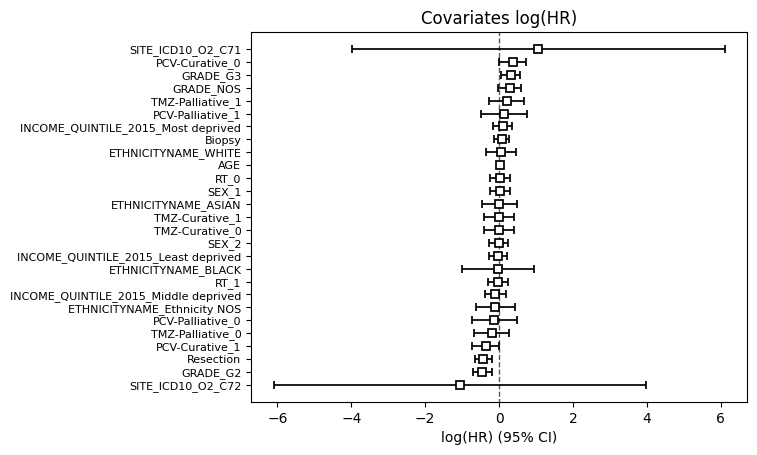

In [267]:
cph.plot()
plt.title('Covariates log(HR)')
plt.yticks(fontsize=8)

## Check assumption and effect size graph

In [268]:
cph.check_assumptions(df_cox, show_plots=True)


Proportional hazard assumption looks okay.


[]

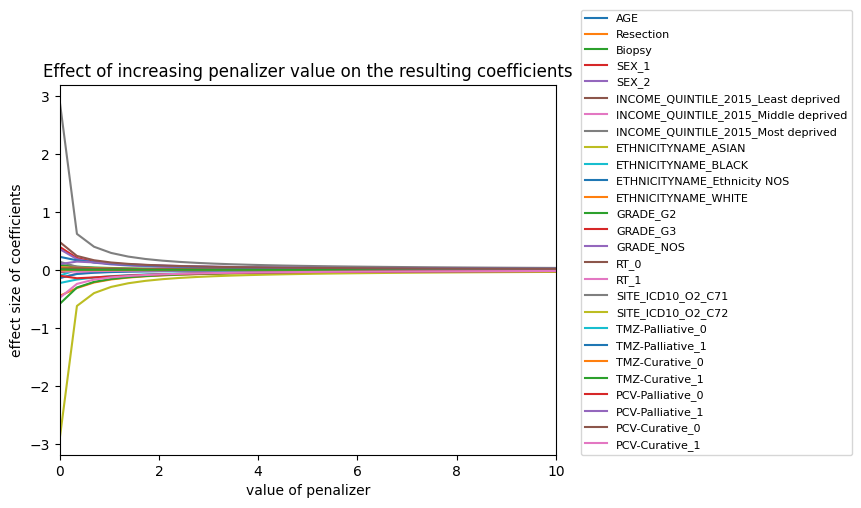

In [269]:
results={}
for p in np.linspace(0.001, 10, 30):
    cph_plus=CoxPHFitter(penalizer=p).fit(df_cox, "INTERVAL_DIAG_TO_VS", "VITALSTATUS")
    results[p] = cph_plus.params_
    
pd.DataFrame(results).T.plot()
plt.xlim(0, 10)
plt.title('Effect of increasing penalizer value on the resulting coefficients')
plt.xlabel('value of penalizer')
plt.ylabel('effect size of coefficients')
plt.legend(bbox_to_anchor=(1.05,0), loc=3, borderaxespad=0, fontsize=8)

## Cox version 5

In [455]:
## firstly we need to deal with NA in GRADE
df['GRADE'].replace('','GX', inplace=True)
df['GRADE'].replace('GX','NOS', inplace=True)
df_cox=df[['PSEUDO_PATIENTID','AGE', 'SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE', 'VITALSTATUS', 'INTERVAL_DIAG_TO_VS', 'SITE_ICD10_O2']]

# Clean data as usual
df_cox['VITALSTATUS'].replace(r'A', 0, inplace=True)
df_cox['VITALSTATUS'].replace(r'D', 1, inplace=True)

## black, asian, white and NOS
df_cox['ETHNICITYNAME'].replace('ANY OTHER BLACK BACKGROUND', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK AFRICAN', 'BLACK', inplace=True)
df_cox['ETHNICITYNAME'].replace('BLACK CARIBBEAN', 'BLACK', inplace=True)

df_cox['ETHNICITYNAME'].replace('CHINESE', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN INDIAN', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ASIAN PAKISTANI', 'ASIAN', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ASIAN BACKGROUND', 'ASIAN', inplace=True)

df_cox['ETHNICITYNAME'].replace('WHITE IRISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('WHITE BRITISH', 'WHITE', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER WHITE BACKGROUND', 'WHITE', inplace=True)

df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT KNOWN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('NOT STATED', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER ETHNIC GROUP', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('ANY OTHER MIXED BACKGROUND', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND ASIAN', 'Ethnicity NOS', inplace=True)
df_cox['ETHNICITYNAME'].replace('MIXED WHITE AND BLACK CARIBBEAN', 'Ethnicity NOS', inplace=True)

## C71 and C72
df_cox['SITE_ICD10_O2'].replace('C725', 'C72', inplace=True)

df_cox['SITE_ICD10_O2'].replace('C710', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C711', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C712', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C713', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C714', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C716', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C718', 'C71', inplace=True)
df_cox['SITE_ICD10_O2'].replace('C719', 'C71', inplace=True)

## Most/middle/Least deprived
df_cox['INCOME_QUINTILE_2015'].replace('1 - Least deprived', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('2', 'Least deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('3', 'Middle deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('4', 'Most deprived', inplace=True)
df_cox['INCOME_QUINTILE_2015'].replace('5 - Most deprived', 'Most deprived', inplace=True)

/tmp/ipykernel_3587902/3772205754.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3772205754.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3772205754.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/3772205754.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [456]:
df_cox['curative_RT']=0
df_cox['palliative_RT']=0

df_cox['PCV-Palliative']=0
df_cox['PCV-Curative']=0
# df_cox['PCV-Adjuvant']=0

df_cox['TMZ-Palliative']=0
df_cox['TMZ-Curative']=0
# df_cox['TMZ-Adjuvant']=0

df_cox['Resection']=0
df_cox['Biopsy']=0

/tmp/ipykernel_3587902/2268155444.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/2268155444.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3587902/2268155444.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [457]:
pcv_r=pcv[pcv.INTENT_OF_TREATMENT == 'C']
pcv_p=pcv[pcv.INTENT_OF_TREATMENT == 'P']
pcv_a=pcv[pcv.INTENT_OF_TREATMENT == 'A']
pcv_n=pcv[pcv.INTENT_OF_TREATMENT == 'N']

tmz_r=tmz[tmz.INTENT_OF_TREATMENT == 'C']
tmz_p=tmz[tmz.INTENT_OF_TREATMENT == 'P']
tmz_a=tmz[tmz.INTENT_OF_TREATMENT == 'A']
tmz_n=tmz[tmz.INTENT_OF_TREATMENT == 'N']

radio_oligo['RTACTUALDOSE'].replace('',np.nan,inplace=True)
radio_oligo.dropna(subset='RTACTUALDOSE', axis=0, inplace=True)

curative_r = radio_oligo.query('RTACTUALDOSE > 40')
palliative_r = radio_oligo.query('RTACTUALDOSE <= 40')

In [458]:
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(curative_r['PSEUDO_PATIENTID']), 'curative_RT'] = 1 # N=89
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(palliative_r['PSEUDO_PATIENTID']), 'palliative_RT'] = 1 # N=386

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_p['PSEUDO_PATIENTID']), 'PCV-Palliative'] = 1  # N=59
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_r['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=17
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_a['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=203
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(pcv_n['PSEUDO_PATIENTID']), 'PCV-Curative'] = 1 # N=2, N(curative)=222

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_p['PSEUDO_PATIENTID']), 'TMZ-Palliative'] = 1  # N=102
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_r['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=52
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_a['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=83
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(tmz_n['PSEUDO_PATIENTID']), 'TMZ-Curative'] = 1 # N=7, N(curative)=142

df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(df_surgery['PSEUDO_PATIENTID']), 'Resection'] = 1  # N=1015
df_cox.loc[df_cox['PSEUDO_PATIENTID'].isin(df_biopsy['PSEUDO_PATIENTID']), 'Biopsy'] = 1  # N=644

In [459]:
# drop id ad get dummies
df_cox.drop(columns='PSEUDO_PATIENTID', inplace=True)
df_cox=pd.get_dummies(df_cox, columns=['SEX', 'INCOME_QUINTILE_2015', 'ETHNICITYNAME', 'GRADE','palliative_RT','curative_RT' ,'SITE_ICD10_O2','TMZ-Palliative','TMZ-Curative','PCV-Palliative', 'PCV-Curative'])

cph=CoxPHFitter(penalizer=0.1)
cox=cph.fit(df_cox, "INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
cox.print_summary()


/tmp/ipykernel_3587902/3480013219.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<lifelines.CoxPHFitter: fitted with 1271 total observations, 978 right-censored observations>
             duration col = 'INTERVAL_DIAG_TO_VS'
                event col = 'VITALSTATUS'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1271
number of events observed = 293
   partial log-likelihood = -1845.70
         time fit was run = 2023-01-12 18:38:04 UTC

---
                                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                    
AGE                                    0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
Resection                             -0.41       0.66       0.12            -0.64            -0.18                 0.53                 0.83
Biopsy                                 0.08       1.08       0.10            -0.12             0.28                 0.89                 1.32
SEX_1                                  0.01       1.01       0.14            -0.26             0.27                 0.77                 1.31
SEX_2                                 -0.01       0.99       0.14            -0.27             0.26                 0.76                 1.30
INCOME_QUINTILE_2015_Least deprived   -0.03       0.97       0.13            -0.28             0.23                 0.76                 1.25
INCOME_QUINTILE_2015_Middle deprived  -0.10       0.90       0.15            -0.39             0.19                 0.68                 1.20
INCOME_QUINTILE_2015_Most deprived     0.10       1.10       0.13            -0.16             0.36                 0.86                 1.43
ETHNICITYNAME_ASIAN                    0.01       1.01       0.25            -0.47             0.50                 0.63                 1.64
ETHNICITYNAME_BLACK                   -0.04       0.96       0.50            -1.02             0.93                 0.36                 2.54
ETHNICITYNAME_Ethnicity NOS           -0.10       0.90       0.27            -0.63             0.43                 0.53                 1.54
ETHNICITYNAME_WHITE                    0.04       1.04       0.20            -0.36             0.44                 0.70                 1.55
GRADE_G2                              -0.46       0.63       0.13            -0.72            -0.20                 0.49                 0.82
GRADE_G3                               0.32       1.37       0.13             0.06             0.57                 1.06                 1.77
GRADE_NOS                              0.28       1.32       0.15            -0.02             0.58                 0.98                 1.78
palliative_RT_0                        0.09       1.09       0.15            -0.21             0.38                 0.81                 1.47
palliative_RT_1                       -0.09       0.92       0.15            -0.38             0.21                 0.68                 1.23
curative_RT_0                         -0.03       0.97       0.27            -0.56             0.50                 0.57                 1.65
curative_RT_1                          0.03       1.03       0.27            -0.50             0.56                 0.61                 1.74
SITE_ICD10_O2_C71                      1.07       2.93       2.57            -3.96             6.11                 0.02               448.77
SITE_ICD10_O2_C72                     -1.07       0.34       2.57            -6.11             3.96                 0.00                52.44
TMZ-Palliative_0                      -0.20       0.82       0.25            -0.68             0.28                 0.50                 1.32
TMZ-Palliative_1                       0.20       1.23       0.25            -0.28             0.68                 0.76                 1.98
TMZ-C

## AFT models --LogLogistics AFT

In [372]:
from lifelines import LogLogisticAFTFitter

df_aft=df_cox
df_aft['INTERVAL_DIAG_TO_VS'].replace(0, 0.001, inplace=True)

aft=LogLogisticAFTFitter(penalizer=0.1)
aft.fit(df_aft,"INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
aft.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 1271 total observations, 978 right-censored observations>
             duration col = 'INTERVAL_DIAG_TO_VS'
                event col = 'VITALSTATUS'
                penalizer = 0.1
   number of observations = 1271
number of events observed = 293
           log-likelihood = -2688.65
         time fit was run = 2023-01-11 03:28:50 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                    
alpha_ AGE                                   -0.03       0.97       0.00            -0.04            -0.03                 0.96                 0.97
       Biopsy                                -0.08       0.93       0.11            -0.29             0.14                 0.75                 1.15
       ETHNICITYNAME_ASIAN                   -0.01       0.99       0.26            -0.52             0.49                 0.59                 1.63
       ETHNICITYNAME_BLACK                    0.15       1.16       0.53            -0.90             1.20                 0.41                 3.31
       ETHNICITYNAME_Ethnicity NOS            0.10       1.11       0.29            -0.46             0.66                 0.63                 1.94
       ETHNICITYNAME_WHITE                   -0.03       0.97       0.21            -0.44             0.38                 0.65                 1.47
       GRADE_G2                               0.50       1.65       0.14             0.24             0.77                 1.27                 2.16
       GRADE_G3                              -0.34       0.71       0.14            -0.61            -0.08                 0.55                 0.93
       GRADE_NOS                             -0.29       0.75       0.16            -0.61             0.03                 0.55                 1.03
       INCOME_QUINTILE_2015_Least deprived    0.05       1.05       0.13            -0.21             0.31                 0.81                 1.36
       INCOME_QUINTILE_2015_Middle deprived   0.10       1.11       0.15            -0.20             0.41                 0.82                 1.50
       INCOME_QUINTILE_2015_Most deprived    -0.11       0.89       0.14            -0.38             0.15                 0.69                 1.17
       PCV-Curative_0                        -0.41       0.66       0.17            -0.74            -0.09                 0.48                 0.92
       PCV-Curative_1                         0.43       1.53       0.17             0.10             0.75                 1.11                 2.12
       PCV-Palliative_0                       0.11       1.12       0.27            -0.42             0.65                 0.66                 1.92
       PCV-Palliative_1                      -0.07       0.93       0.27            -0.61             0.46                 0.54                 1.59
       Resection                              0.48       1.62       0.13             0.22             0.74                 1.25                 2.10
       SEX_1                                  0.01       1.01       0.14            -0.26             0.29                 0.77                 1.33
       SEX_2                                 -0.00       1.00       0.14            -0.28             0.27                 0.76                 1.31
       SITE_ICD10_O2_C71                      0.97       2.64       2.46            -3.86             5.80                 0.02               330.27
       SITE_ICD10_O2_C72                      2.38      10.82       2.46            -2.45             7.21                 0.09              1355.51
       TMZ-Curative_0                         0.02       1.02       0.22            -0.41             0.45                 0.66                 1.57
       TMZ-Curative_1                 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 [Text(0, 0, 'PCV-Curative_0: alpha_'),
  Text(0, 1, 'GRADE_G3: alpha_'),
  Text(0, 2, 'GRADE_NOS: alpha_'),
  Text(0, 3, 'TMZ-Palliative_1: alpha_'),
  Text(0, 4, 'PCV-Palliative_1: alpha_'),
  Text(0, 5, 'INCOME_QUINTILE_2015_Most deprived: alpha_'),
  Text(0, 6, 'RT_0: alpha_'),
  Text(0, 7, 'Biopsy: alpha_'),
  Text(0, 8, 'ETHNICITYNAME_WHITE: alpha_'),
  Text(0, 9, 'AGE: alpha_'),
  Text(0, 10, 'TMZ-Curative_1: alpha_'),
  Text(0, 11, 'SEX_2: alpha_'),
  Text(0, 12, 'ETHNICITYNAME_ASIAN: alpha_'),
  Text(0, 13, 'SEX_1: alpha_'),
  Text(0, 14, 'TMZ-Curative_0: alpha_'),
  Text(0, 15, 'INCOME_QUINTILE_2015_Least deprived: alpha_'),
  Text(0, 16, 'RT_1: alpha_'),
  Text(0, 17, 'ETHNICITYNAME_Ethnicity NOS: alpha_'),
  Text(0, 18, 'INCOME_QUINTILE_2015_Middle deprived: alpha_'),
  Text(0, 19, 'ETHNICITYNAME_BLACK: alpha_'),
  Text(0, 20, 'TMZ-Palliative

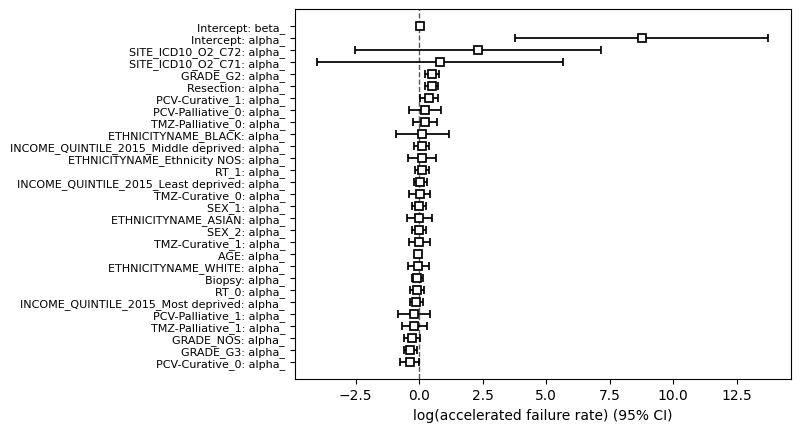

In [271]:
aft.plot()
plt.yticks(fontsize=8)

## Weibull AFT

In [486]:
from lifelines import WeibullAFTFitter

df_wft=df_cox
df_wft['INTERVAL_DIAG_TO_VS'].replace(0, 0.001, inplace=True)

wft = WeibullAFTFitter(penalizer=0.1)
wft.fit(df_wft,"INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
wft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 1271 total observations, 978 right-censored observations>
             duration col = 'INTERVAL_DIAG_TO_VS'
                event col = 'VITALSTATUS'
                penalizer = 0.1
   number of observations = 1271
number of events observed = 293
           log-likelihood = -2681.21
         time fit was run = 2023-01-13 00:32:55 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                    
lambda_ AGE                                   -0.03       0.97       0.00            -0.04            -0.03                 0.96                 0.97
        Biopsy                                -0.08       0.92       0.11            -0.29             0.12                 0.75                 1.13
        ETHNICITYNAME_ASIAN                   -0.01       0.99       0.25            -0.51             0.48                 0.60                 1.62
        ETHNICITYNAME_BLACK                    0.04       1.04       0.52            -0.97             1.06                 0.38                 2.88
        ETHNICITYNAME_Ethnicity NOS            0.11       1.11       0.28            -0.44             0.66                 0.64                 1.93
        ETHNICITYNAME_WHITE                   -0.04       0.96       0.21            -0.45             0.36                 0.64                 1.43
        GRADE_G2                               0.48       1.62       0.13             0.22             0.75                 1.24                 2.11
        GRADE_G3                              -0.33       0.72       0.13            -0.59            -0.07                 0.56                 0.94
        GRADE_NOS                             -0.29       0.75       0.16            -0.60             0.01                 0.55                 1.01
        INCOME_QUINTILE_2015_Least deprived    0.03       1.03       0.13            -0.23             0.28                 0.79                 1.33
        INCOME_QUINTILE_2015_Middle deprived   0.11       1.11       0.15            -0.19             0.40                 0.83                 1.50
        INCOME_QUINTILE_2015_Most deprived    -0.10       0.90       0.13            -0.36             0.15                 0.69                 1.17
        PCV-Curative_0                        -0.41       0.66       0.17            -0.74            -0.09                 0.48                 0.91
        PCV-Curative_1                         0.41       1.51       0.17             0.09             0.74                 1.09                 2.09
        PCV-Palliative_0                       0.04       1.04       0.27            -0.49             0.57                 0.61                 1.77
        PCV-Palliative_1                      -0.04       0.96       0.27            -0.57             0.49                 0.57                 1.63
        Resection                              0.44       1.56       0.12             0.20             0.68                 1.22                 1.98
        SEX_1                                 -0.00       1.00       0.14            -0.27             0.27                 0.76                 1.30
        SEX_2                                  0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
        SITE_ICD10_O2_C71                     -1.12       0.33       2.57            -6.17             3.93                 0.00                50.74
        SITE_ICD10_O2_C72                      1.12       3.06       2.57            -3.93             6.17                 0.02               476.08
        TMZ-Curative_0                        -0.00       1.00       0.22            -0.43             0.42                 0.65                 1.53
        TMZ-Curati

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 [Text(0, 0, 'SITE_ICD10_O2_C71: lambda_'),
  Text(0, 1, 'PCV-Curative_0: lambda_'),
  Text(0, 2, 'GRADE_G3: lambda_'),
  Text(0, 3, 'GRADE_NOS: lambda_'),
  Text(0, 4, 'TMZ-Palliative_1: lambda_'),
  Text(0, 5, 'PCV-Palliative_1: lambda_'),
  Text(0, 6, 'INCOME_QUINTILE_2015_Most deprived: lambda_'),
  Text(0, 7, 'Biopsy: lambda_'),
  Text(0, 8, 'ETHNICITYNAME_WHITE: lambda_'),
  Text(0, 9, 'RT_0: lambda_'),
  Text(0, 10, 'AGE: lambda_'),
  Text(0, 11, 'SEX_1: lambda_'),
  Text(0, 12, 'ETHNICITYNAME_ASIAN: lambda_'),
  Text(0, 13, 'TMZ-Curative_0: lambda_'),
  Text(0, 14, 'TMZ-Curative_1: lambda_'),
  Text(0, 15, 'SEX_2: lambda_'),
  Text(0, 16, 'INCOME_QUINTILE_2015_Least deprived: lambda_'),
  Text(0, 17, 'ETHNICITYNAME_BLACK: lambda_'),
  Text(0, 18, 'RT_1: lambda_'),
  Text(0, 19, 'INCOME_QUINTILE_2015_Middle deprived: lambda_'),
  Text(0, 20, 'ETHN

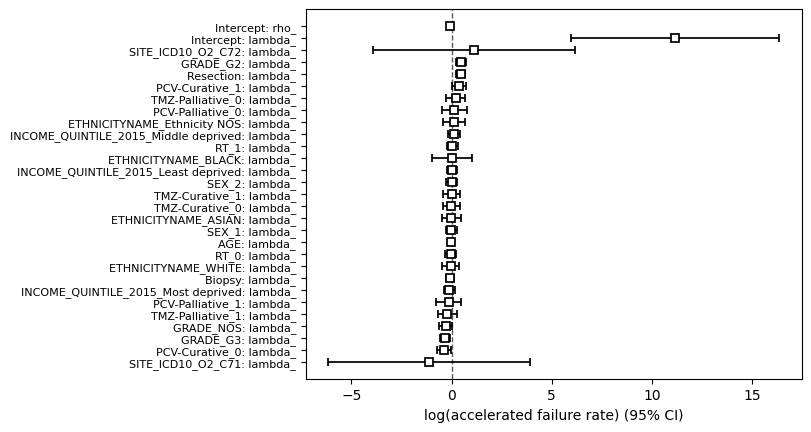

In [279]:
wft.plot()
plt.yticks(fontsize=8)

## Find best model -- AIC

In [386]:
from lifelines.utils import find_best_parametric_model

best_model, best_aic = find_best_parametric_model(event_times=df_aft["INTERVAL_DIAG_TO_VS"],event_observed=df_aft["VITALSTATUS"], scoring_method='AIC')
print(best_model)
print(best_aic)

## this is definitly not the best aic, because 3000+ AIC was found in COX

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1271 total observations, 978 right-censored observations>
5580.224442205113


## Find best model -- BIC

In [384]:
from lifelines.utils import find_best_parametric_model

best_model, best_aic = find_best_parametric_model(event_times=df_cox["INTERVAL_DIAG_TO_VS"],event_observed=df_cox["VITALSTATUS"], scoring_method='BIC')
print(best_model)

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1271 total observations, 978 right-censored observations>


In [380]:
from lifelines import WeibullFitter

df_wb=df_cox
df_wb['INTERVAL_DIAG_TO_VS'].replace(0, 0.001, inplace=True)

wb = WeibullFitter()
wb.fit(df_wb["INTERVAL_DIAG_TO_VS"], df_wb["VITALSTATUS"])
wb.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1271 total observations, 978 right-censored observations>
   number of observations = 1271
number of events observed = 293
           log-likelihood = -2788.11
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 8331.91    1050.77          6272.44         10391.38
rho_       0.75       0.04             0.67             0.82

          cmp to     z      p   -log2(p)
lambda_     1.00  7.93 <0.005      48.68
rho_        1.00 -6.31 <0.005      31.72
---
AIC = 5580.22

## Buil quintile-quintile graph, (abandoned)

## Nelson Aalen Fitter

<AxesSubplot: xlabel='timeline'>

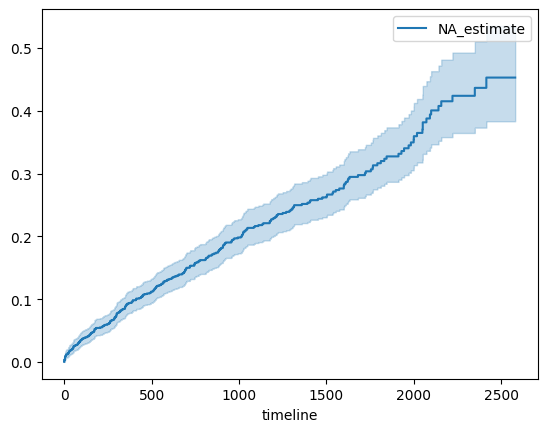

In [404]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(durations=df_cox["INTERVAL_DIAG_TO_VS"], event_observed=df_cox["VITALSTATUS"])
naf.plot()

In [447]:
# from lifelines import AalenAdditiveFitter
# aaf = AalenAdditiveFitter(coef_penalizer=0.1,smoothing_penalizer=0.1)
# aaf.fit(df_wft,"INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
# aaf.print_summary()

In [418]:
# from lifelines import CRCSplineFitter
# crc = CRCSplineFitter(n_baseline_knots=1271)
# crc.fit(df_wft,"INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
# crc.print_summary()

## LogNormalAFTFitter

In [432]:
from lifelines import LogNormalAFTFitter
lna = LogNormalAFTFitter(penalizer=0.1)
lna.fit(df_aft,"INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
lna.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1271 total observations, 978 right-censored observations>
             duration col = 'INTERVAL_DIAG_TO_VS'
                event col = 'VITALSTATUS'
                penalizer = 0.1
   number of observations = 1271
number of events observed = 293
           log-likelihood = -2783.94
         time fit was run = 2023-01-12 03:11:50 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                    
mu_    AGE                                   -0.03       0.97       0.00            -0.04            -0.02                 0.96                 0.98
       Biopsy                                 0.00       1.00       0.12            -0.23             0.24                 0.79                 1.27
       ETHNICITYNAME_ASIAN                   -0.06       0.94       0.27            -0.58             0.46                 0.56                 1.59
       ETHNICITYNAME_BLACK                    0.29       1.34       0.59            -0.86             1.44                 0.42                 4.23
       ETHNICITYNAME_Ethnicity NOS           -0.11       0.89       0.29            -0.69             0.46                 0.50                 1.58
       ETHNICITYNAME_WHITE                    0.05       1.06       0.21            -0.36             0.47                 0.70                 1.60
       GRADE_G2                               0.57       1.76       0.14             0.29             0.84                 1.34                 2.32
       GRADE_G3                              -0.38       0.68       0.14            -0.66            -0.11                 0.52                 0.90
       GRADE_NOS                             -0.35       0.71       0.17            -0.69            -0.01                 0.50                 0.99
       INCOME_QUINTILE_2015_Least deprived    0.08       1.09       0.14            -0.19             0.35                 0.83                 1.42
       INCOME_QUINTILE_2015_Middle deprived   0.08       1.08       0.16            -0.24             0.39                 0.79                 1.48
       INCOME_QUINTILE_2015_Most deprived    -0.14       0.87       0.14            -0.42             0.13                 0.66                 1.14
       PCV-Curative_0                        -0.49       0.62       0.17            -0.82            -0.15                 0.44                 0.86
       PCV-Curative_1                         0.49       1.62       0.17             0.15             0.82                 1.17                 2.26
       PCV-Palliative_0                       0.06       1.07       0.28            -0.49             0.61                 0.61                 1.85
       PCV-Palliative_1                      -0.06       0.94       0.28            -0.61             0.49                 0.54                 1.63
       Resection                              0.61       1.84       0.15             0.32             0.89                 1.38                 2.45
       SEX_1                                  0.05       1.06       0.14            -0.22             0.33                 0.80                 1.40
       SEX_2                                 -0.05       0.95       0.14            -0.33             0.22                 0.72                 1.25
       SITE_ICD10_O2_C71                     -1.14       0.32       2.64            -6.31             4.03                 0.00                56.23
       SITE_ICD10_O2_C72                      1.14       3.14       2.64            -4.03             6.31                 0.02               552.75
       TMZ-Curative_0                        -0.05       0.95       0.23            -0.49             0.39                 0.61                 1.48
       TMZ-Curative_1                   

In [444]:
# from lifelines import PiecewiseExponentialRegressionFitter
# per = PiecewiseExponentialRegressionFitter(breakpoints=(0,30,60,90), penalizer=0.1)
# per.fit(df_aft,"INTERVAL_DIAG_TO_VS", event_col="VITALSTATUS")
# per.print_summary()

In [487]:
df.groupby('BIGTUMOURCOUNT')['PSEUDO_PATIENTID'].nunique()

BIGTUMOURCOUNT
1    1127
2     131
3      11
4       2
Name: PSEUDO_PATIENTID, dtype: int64